## Imports

In [2]:
import math
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from my_ecog_utils import read_with_annotations, get_multitaper_power_bands

## Power Calcs

In [3]:
pts_w_any_stim = [100, 103, 105, 106, 109, 110, 111, 112, 113, 115]
freqs = ['Delta', 'Theta', 'Alpha', 'Beta', 'GammaLow', 'GammaMed', 'GammaHigh', 'GammaXHigh']

results_before_after = pd.DataFrame(columns=['ID', 'Stim', 'Trial', 'Channel', 'Delta', 'Theta', 'Alpha', 'Beta'])
results_before_after.loc[:,'Stim'] = results_before_after['Stim'].astype('bool')

for pt_num in pts_w_any_stim:
    raw = read_with_annotations(pt_num)
    if pt_num in [100, 103, 112, 115]:
        raw.load_data()
        raw.notch_filter(62.5)

    evts, event_id = mne.events_from_annotations(raw, {'BAD_': 0, 'post_shock': 2, 'pre_shock': 1})
    epochs = mne.Epochs(raw, evts, event_id=event_id, tmin=0, tmax=1, baseline=(0.5,1.0))

    if pt_num == 100:
        epochs.rename_channels({'Hip1 - Hip2': 'LHip1 - LHip2', 'Hip3 - Hip4': 'LHip3 - LHip4'})
    elif pt_num == 113:
        epochs.rename_channels(lambda s: s.replace('H', 'Hip'))

    # drop segments that overlap with shocks
    # i.e. those that are shorter than 1 second. May change tmax in the future
    epochs.drop_bad()
    
    # if you ever need to debug, look at the drop logs
    print(epochs.drop_log)
    trial_num = 0
    epoch_num = 0
    shock_num = 1
    for i in range(len(epochs.drop_log)):
        epoch = epochs[epoch_num]
        shock_num += 1
        if epochs.drop_log[i] == ('BAD_',):
            continue
        is_post_stim = 'post_shock' in epoch.event_id
        if not is_post_stim:
            trial_num += 1
            shock_num = 0
        for chan in epochs.ch_names:
            powers = get_multitaper_power_bands(epoch, picks=chan, split_gamma=True)
            results_before_after = results_before_after.append({'ID': pt_num, 'Stim': is_post_stim, 'Trial': trial_num, 'Channel': chan, 'Stim_Num': shock_num, **powers}, ignore_index=True)
        epoch_num += 1

results_before_after.to_csv('each_stim_before_after.csv', index=False)
results_before_after

Opening raw data file data/100/stimulated_ieeg.fif...
Isotrak not found
    Range : 0 ... 51647 =      0.000 ...   206.588 secs
Ready.
Reading 0 ... 51647  =      0.000 ...   206.588 secs...
Setting up band-stop filter from 62 - 63 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.84
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 61.59 Hz)
- Upper passband edge: 63.16 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.41 Hz)
- Filter length: 1651 samples (6.604 sec)

Used Annotations descriptions: ['post_shock', 'pre_shock']
Not setting metadata
Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 15 events and 251 original time points ...
0 bad epochs dropped
((), (),

c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)


ID   Stim Trial        Channel         Delta         Theta  \
0    100  False     1  LHip1 - LHip2  7.676245e-08  7.966128e-08   
1    100  False     1  LHip3 - LHip4  7.599882e-08  5.435899e-08   
2    100  False     1  LatT1 - LatT2  1.777491e-09  1.945915e-09   
3    100  False     1  LatT3 - LatT4  1.063224e-08  1.579306e-08   
4    100   True     1  LHip1 - LHip2  1.142425e-07  7.161263e-08   
..   ...    ...   ...            ...           ...           ...   
559  115   True     3  RHip3 - RHip4  9.366525e-08  3.898334e-08   
560  115   True     3  LHip1 - LHip2  7.930484e-08  3.846025e-08   
561  115   True     3  LHip3 - LHip4  2.255593e-08  1.187012e-08   
562  115   True     3  RHip1 - RHip2  9.711323e-08  5.704873e-08   
563  115   True     3  RHip3 - RHip4  9.523928e-08  4.836225e-08   

            Alpha          Beta     GammaHigh      GammaLow      GammaMed  \
0    3.897899e-08  1.350653e-08  1.342159e-10  1.014126e-09  2.448737e-10   
1    7.955522e-09  3.615457e-09  5.158829e-11  8.472699e-10  8.771663e-11   
2    7.836614e-10  2.448647e-10  1.145110e-11  5.035184e-11  1.546049e-11   
3    8.962653e-09  1.447087e-09  2.411582e-11  2.195220e-10  4.948296e-11   
4    2.537439e-08  1.169223e-08  9.841945e-11  9.902345e-10  3.155199e-10   
..            ...           ...           ...           ...           ...   
559  1.177374e-08  1.676138e-09  1.791777e-11  3.895446e-10  5.332189e-11   
560  8.028031e-09  1.502573e-09  3.572770e-11  1.697749e-10  3.836565e-11   
561  4.359613e-09  1.080279e-09  1.285633e-11  1.064493e-10  2.419334e-11   
562  2.026480e-08  1.892534e-09  8.060189e-12  1.437498e-10  3.017192e-11   
563  8.531949e-09  1.652413e-09  1.272977e-11  1.843308e-10  3.432542e-11   

       GammaXHigh  Stim_Num  
0    3.160809e-11       0.0  
1    2.150510e-11       0.0  
2    7.259526e-12       0.0  
3    2.017395e-11       0.0  
4    4.089712e-11       1.0  
..            ...       ...  
559  8.744541e-12       3.0  
560  1.114447e-11       4.0  
561  7.072084e-12       4.0  
562  6.532877e-12       4.0  
563  7.688247e-12       4.0  

[564 rows x 13 columns]

In [4]:
results_before_after['Stim_Num'] = results_before_after['Stim_Num'].astype(int)

baselines = results_before_after[results_before_after['Stim'] == False]
stims = results_before_after[results_before_after['Stim'] == True]
rearranged = stims.merge(baselines, on=['ID', 'Trial', 'Channel'], suffixes=['_post', '_pre'])
rearranged = rearranged.drop(['Stim_post', 'Stim_pre'], axis='columns')

for freq in freqs:
    rearranged[freq+'_pct'] = (rearranged[freq+'_post'] - rearranged[freq+'_pre']) / rearranged[freq+'_pre'] * 100

In [5]:
power_log_chg = rearranged.copy()
for freq in freqs:
    power_log_chg = power_log_chg.drop(freq+'_pct', axis=1)
    power_log_chg[freq+'_log_chg'] = np.log10(rearranged[freq+'_post']) - np.log10(rearranged[freq+'_pre'])
power_log_chg = power_log_chg.drop('Stim_Num_pre', axis=1).rename({'Stim_Num_post': 'Stim_Num'}, axis=1)
power_log_chg

ID Trial        Channel    Delta_post    Theta_post    Alpha_post  \
0    100     1  LHip1 - LHip2  1.142425e-07  7.161263e-08  2.537439e-08   
1    100     1  LHip1 - LHip2  5.835947e-08  3.228662e-08  2.086371e-08   
2    100     1  LHip1 - LHip2  5.101078e-08  3.540437e-08  3.576591e-08   
3    100     1  LHip1 - LHip2  8.638911e-08  8.010154e-08  4.598185e-08   
4    100     1  LHip3 - LHip4  3.784396e-07  7.526684e-08  5.945997e-09   
..   ...   ...            ...           ...           ...           ...   
443  115     3  RHip1 - RHip2  9.711323e-08  5.704873e-08  2.026480e-08   
444  115     3  RHip3 - RHip4  1.015564e-07  2.902442e-08  3.397387e-09   
445  115     3  RHip3 - RHip4  3.798705e-08  1.329936e-08  2.844349e-09   
446  115     3  RHip3 - RHip4  9.366525e-08  3.898334e-08  1.177374e-08   
447  115     3  RHip3 - RHip4  9.523928e-08  4.836225e-08  8.531949e-09   

        Beta_post  GammaHigh_post  GammaLow_post  GammaMed_post  ...  \
0    1.169223e-08    9.841945e-11   9.902345e-10   3.155199e-10  ...   
1    8.328850e-09    1.467862e-10   1.225056e-09   2.848021e-10  ...   
2    1.402683e-08    1.111660e-10   9.843672e-10   1.900451e-10  ...   
3    9.420390e-09    8.058547e-11   5.373972e-10   1.538000e-10  ...   
4    3.396220e-09    8.039247e-11   8.468632e-10   1.507339e-10  ...   
..            ...             ...            ...            ...  ...   
443  1.892534e-09    8.060189e-12   1.437498e-10   3.017192e-11  ...   
444  1.678384e-09    1.615187e-11   2.144958e-10   3.442140e-11  ...   
445  1.064764e-09    1.487083e-11   1.788814e-10   2.827297e-11  ...   
446  1.676138e-09    1.791777e-11   3.895446e-10   5.332189e-11  ...   
447  1.652413e-09    1.272977e-11   1.843308e-10   3.432542e-11  ...   

     GammaMed_pre  GammaXHigh_pre  Delta_log_chg  Theta_log_chg  \
0    2.448737e-10    3.160809e-11       0.172679      -0.046258   
1    2.448737e-10    3.160809e-11      -0.119037      -0.392225   
2    2.448737e-10    3.160809e-11      -0.177487      -0.352190   
3    2.448737e-10    3.160809e-11       0.051310       0.002394   
4    8.771663e-11    2.150510e-11       0.697190       0.141332   
..            ...             ...            ...            ...   
443  3.254691e-11    7.662699e-12       0.181484       0.656745   
444  2.906567e-11    8.505188e-12       0.232041       0.275843   
445  2.906567e-11    8.505188e-12      -0.195031      -0.063090   
446  2.906567e-11    8.505188e-12       0.196912       0.403959   
447  2.906567e-11    8.505188e-12       0.204150       0.497586   

     Alpha_log_chg  Beta_log_chg  GammaLow_log_chg  GammaMed_log_chg  \
0        -0.186435     -0.062647         -0.010354          0.110085   
1        -0.271439     -0.209959          0.082064          0.065601   
2        -0.037361      0.016416         -0.012935         -0.110085   
3         0.071756     -0.156475         -0.275796         -0.201986   
4        -0.126444     -0.027167         -0.000208          0.235129   
..             ...           ...               ...               ...   
443       0.410674      0.016787         -0.056362         -0.032907   
444      -0.144449     -0.043531         -0.234820          0.073448   
445      -0.221611     -0.241169         -0.313673         -0.012009   
446       0.395321     -0.044113          0.024319          0.263525   
447       0.255454     -0.050304         -0.300641          0.072235   

     GammaHigh_log_chg  GammaXHigh_log_chg  
0            -0.134723            0.111894  
1             0.038881            0.058941  
2            -0.081832           -0.153179  
3            -0.221547            0.139011  
4             0.192664            0.121860  
..                 ...                 ...  
443          -0.240771           -0.069277  
444          -0.037140            0.088119  
445          -0.073028           -0.036095  
446           0.007921            0.012053  
447          -0.140543           -0.043857  

[448 rows x 28 columns]

## Get Memory Data

In [6]:
memory_trials = pd.read_csv('memory_trials.csv').iloc[:,1:]
memory_trials = memory_trials.drop(11, axis=0)
memory_trials['ID'] = memory_trials['ID'].astype(int)

memory_trials = memory_trials.set_index(['ID', 'Avg_Sham']).stack().to_frame()
memory_trials['Trial'] = memory_trials.index.get_level_values(2)
memory_trials['Trial'] = memory_trials['Trial'].str[len('Trial_')].astype(int)
memory_trials = memory_trials.reset_index(level=2)
memory_trials = memory_trials[~memory_trials['level_2'].str.endswith('Sham')]
memory_trials = memory_trials.drop('level_2', axis=1)
memory_trials = memory_trials.rename(columns={0: 'Memory_Score'})
memory_trials = memory_trials.reset_index(level=1)
memory_trials

Avg_Sham  Memory_Score  Trial
ID                                
100  7.666667             4      1
100  7.666667             6      2
100  7.666667             6      3
101  6.666667             3      1
101  6.666667             5      2
..        ...           ...    ...
208  0.000000             8      2
208  0.000000            11      3
209  0.000000             5      1
209  0.000000             6      2
209  0.000000             8      3

[66 rows x 3 columns]

In [7]:
power_and_mem = power_log_chg.merge(memory_trials, on=['ID', 'Trial'], how='left')
power_and_mem = power_and_mem.dropna()
memory_delayed = pd.read_csv('memory_delayed.csv').iloc[:,1:]
memory_delayed = memory_delayed.rename({'Memory_Stim': 'Delay_Mem_Stim', 'Memory_Sham': 'Delay_Mem_Sham'}, axis=1)
power_and_mem = power_and_mem.merge(memory_delayed, on='ID', how='left')
power_and_mem

ID Trial        Channel    Delta_post    Theta_post    Alpha_post  \
0    100     1  LHip1 - LHip2  1.142425e-07  7.161263e-08  2.537439e-08   
1    100     1  LHip1 - LHip2  5.835947e-08  3.228662e-08  2.086371e-08   
2    100     1  LHip1 - LHip2  5.101078e-08  3.540437e-08  3.576591e-08   
3    100     1  LHip1 - LHip2  8.638911e-08  8.010154e-08  4.598185e-08   
4    100     1  LHip3 - LHip4  3.784396e-07  7.526684e-08  5.945997e-09   
..   ...   ...            ...           ...           ...           ...   
411  115     3  RHip1 - RHip2  9.711323e-08  5.704873e-08  2.026480e-08   
412  115     3  RHip3 - RHip4  1.015564e-07  2.902442e-08  3.397387e-09   
413  115     3  RHip3 - RHip4  3.798705e-08  1.329936e-08  2.844349e-09   
414  115     3  RHip3 - RHip4  9.366525e-08  3.898334e-08  1.177374e-08   
415  115     3  RHip3 - RHip4  9.523928e-08  4.836225e-08  8.531949e-09   

        Beta_post  GammaHigh_post  GammaLow_post  GammaMed_post  ...  \
0    1.169223e-08    9.841945e-11   9.902345e-10   3.155199e-10  ...   
1    8.328850e-09    1.467862e-10   1.225056e-09   2.848021e-10  ...   
2    1.402683e-08    1.111660e-10   9.843672e-10   1.900451e-10  ...   
3    9.420390e-09    8.058547e-11   5.373972e-10   1.538000e-10  ...   
4    3.396220e-09    8.039247e-11   8.468632e-10   1.507339e-10  ...   
..            ...             ...            ...            ...  ...   
411  1.892534e-09    8.060189e-12   1.437498e-10   3.017192e-11  ...   
412  1.678384e-09    1.615187e-11   2.144958e-10   3.442140e-11  ...   
413  1.064764e-09    1.487083e-11   1.788814e-10   2.827297e-11  ...   
414  1.676138e-09    1.791777e-11   3.895446e-10   5.332189e-11  ...   
415  1.652413e-09    1.272977e-11   1.843308e-10   3.432542e-11  ...   

     Alpha_log_chg  Beta_log_chg  GammaLow_log_chg  GammaMed_log_chg  \
0        -0.186435     -0.062647         -0.010354          0.110085   
1        -0.271439     -0.209959          0.082064          0.065601   
2        -0.037361      0.016416         -0.012935         -0.110085   
3         0.071756     -0.156475         -0.275796         -0.201986   
4        -0.126444     -0.027167         -0.000208          0.235129   
..             ...           ...               ...               ...   
411       0.410674      0.016787         -0.056362         -0.032907   
412      -0.144449     -0.043531         -0.234820          0.073448   
413      -0.221611     -0.241169         -0.313673         -0.012009   
414       0.395321     -0.044113          0.024319          0.263525   
415       0.255454     -0.050304         -0.300641          0.072235   

     GammaHigh_log_chg  GammaXHigh_log_chg  Avg_Sham  Memory_Score  \
0            -0.134723            0.111894  7.666667           4.0   
1             0.038881            0.058941  7.666667           4.0   
2            -0.081832           -0.153179  7.666667           4.0   
3            -0.221547            0.139011  7.666667           4.0   
4             0.192664            0.121860  7.666667           4.0   
..                 ...                 ...       ...           ...   
411          -0.240771           -0.069277  5.000000           5.0   
412          -0.037140            0.088119  5.000000           5.0   
413          -0.073028           -0.036095  5.000000           5.0   
414           0.007921            0.012053  5.000000           5.0   
415          -0.140543           -0.043857  5.000000           5.0   

     Delay_Mem_Stim  Delay_Mem_Sham  
0               4.0               5  
1               4.0               5  
2               4.0               5  
3               4.0               5  
4               4.0               5  
..              ...             ...  
411             4.0               5  
412             4.0               5  
413             4.0               5  
414             4.0               5  
415             4.0               5  

[416 rows x 32 columns]

## Mixed Effects Models

In [8]:
power_mem_trial = pd.DataFrame()
for freq in freqs:
    x_for_freq = '$FREQ_post'.replace('$FREQ', freq)
    power_mem_trial[x_for_freq] = power_and_mem.groupby(['ID', 'Trial', 'Channel'])[x_for_freq].mean()
    x_for_freq = '$FREQ_pre'.replace('$FREQ', freq)
    power_mem_trial[x_for_freq] = power_and_mem.groupby(['ID', 'Trial', 'Channel'])[x_for_freq].mean()
    x_for_freq = '$FREQ_log_chg'.replace('$FREQ', freq)
    power_mem_trial[x_for_freq] = power_and_mem.groupby(['ID', 'Trial', 'Channel'])[x_for_freq].mean()
    
df_mems = power_and_mem.groupby(['ID', 'Trial', 'Channel']).mean()
for col in df_mems.columns:
    if col in ['Memory_Score', 'Avg_Sham', 'Change_in_Memory']:
        power_mem_trial[col] = df_mems[col]
power_mem_trial = power_mem_trial.reset_index()

In [10]:
hip_chans = ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']

## End Setup

In [11]:
raise Exception()

Exception: 

In [9]:
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf
from IPython.display import display

for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    formula = "Memory_Score ~ "
    for freq in freqs:
        formula += "np.log10("+freq+"_pre) + "
    formula = formula[:-3]
    model = smf.mixedlm(formula, power_for_chan, groups=power_for_chan['ID'])
    result = model.fit()
    print(chan+":")
    display(result.summary())

NameError: name 'hip_chans' is not defined

In [ ]:
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf
from IPython.display import display

for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    formula = "Change_in_Memory ~ "
    for freq in freqs:
        formula += "np.log10("+freq+"_pre) + "
    formula = formula[:-3]
    model = smf.mixedlm(formula, power_for_chan, groups=power_for_chan['ID'])
    result = model.fit()
    print(chan+":")
    display(result.summary())

LHip1 - LHip2:


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:              MixedLM   Dependent Variable:   Change_in_Memory
No. Observations:   18        Method:               REML            
No. Groups:         6         Scale:                2.2847          
Min. group size:    3         Log-Likelihood:       -17.7265        
Max. group size:    3         Converged:            Yes             
Mean group size:    3.0                                             
--------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------
Intercept                -3.109   28.856 -0.108 0.914 -59.665 53.448
np.log10(Delta_pre)       5.819    3.810  1.527 0.127  -1.648 13.287
np.log10(Theta_pre)      -7.870    5.210 -1.511 0.131 -18.080  2.341
np.log10(Alpha_pre)       2.887    3.598  0.802 0.422  -4.166  9.939
np.log10(Beta_pre)        2.460    2.580  0.954 0.340  -2.597  7.518
np.log10(GammaLow_pre)   -5.372    4.343 -1.237 0.216 -13.885  3.141
np.log10(GammaMed_pre)   -2.273    2.884 -0.788 0.430  -7.925  3.379
np.log10(GammaHigh_pre)   2.074    5.206  0.398 0.690  -8.130 12.278
np.log10(GammaXHigh_pre)  2.030    4.570  0.444 0.657  -6.927 10.986
Group Var                 3.245    2.959                            
====================================================================

"""

c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


LHip3 - LHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.008522
  warnings.warn(msg, ConvergenceWarning)
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2705: RuntimeWarning: invalid v

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:              MixedLM   Dependent Variable:   Change_in_Memory
No. Observations:   18        Method:               REML            
No. Groups:         6         Scale:                3.0503          
Min. group size:    3         Log-Likelihood:       -16.9250        
Max. group size:    3         Converged:            No              
Mean group size:    3.0                                             
--------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------
Intercept                -8.564   14.910 -0.574 0.566 -37.786 20.658
np.log10(Delta_pre)       4.405    3.759  1.172 0.241  -2.962 11.771
np.log10(Theta_pre)      -5.214    4.373 -1.193 0.233 -13.784  3.356
np.log10(Alpha_pre)      -3.396                                     
np.log10(Beta_pre)        2.938    1.044  2.815 0.005   0.892  4.984
np.log10(GammaLow_pre)   -7.019                                     
np.log10(GammaMed_pre)   11.269                                     
np.log10(GammaHigh_pre)  -2.998    4.128 -0.726 0.468 -11.088  5.093
np.log10(GammaXHigh_pre) -1.462    2.246 -0.651 0.515  -5.865  2.940
Group Var                 0.001                                     
====================================================================

"""

RHip1 - RHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:              MixedLM   Dependent Variable:   Change_in_Memory
No. Observations:   18        Method:               REML            
No. Groups:         6         Scale:                1.4732          
Min. group size:    3         Log-Likelihood:       -14.5609        
Max. group size:    3         Converged:            Yes             
Mean group size:    3.0                                             
--------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------
Intercept                10.150   11.537  0.880 0.379 -12.461 32.762
np.log10(Delta_pre)      -0.689    1.735 -0.397 0.691  -4.090  2.712
np.log10(Theta_pre)      -0.000    2.212 -0.000 1.000  -4.336  4.335
np.log10(Alpha_pre)       0.723    3.104  0.233 0.816  -5.360  6.806
np.log10(Beta_pre)       -1.001    3.957 -0.253 0.800  -8.757  6.755
np.log10(GammaLow_pre)    2.230    1.506  1.481 0.139  -0.721  5.181
np.log10(GammaMed_pre)    5.046    2.955  1.708 0.088  -0.745 10.838
np.log10(GammaHigh_pre)  -5.308    3.713 -1.430 0.153 -12.585  1.969
np.log10(GammaXHigh_pre)  0.105    2.994  0.035 0.972  -5.762  5.973
Group Var                 0.000                                     
====================================================================

"""

c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


RHip3 - RHip4:


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:              MixedLM   Dependent Variable:   Change_in_Memory
No. Observations:   15        Method:               REML            
No. Groups:         5         Scale:                0.5785          
Min. group size:    3         Log-Likelihood:       -4.2641         
Max. group size:    3         Converged:            Yes             
Mean group size:    3.0                                             
--------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------
Intercept                -9.958   15.765 -0.632 0.528 -40.857 20.941
np.log10(Delta_pre)      -0.548    1.850 -0.296 0.767  -4.173  3.078
np.log10(Theta_pre)      -0.706    3.403 -0.207 0.836  -7.376  5.963
np.log10(Alpha_pre)      -1.227    2.822 -0.435 0.664  -6.757  4.303
np.log10(Beta_pre)        3.487    2.640  1.321 0.187  -1.687  8.661
np.log10(GammaLow_pre)    0.227    2.067  0.110 0.913  -3.825  4.279
np.log10(GammaMed_pre)    7.012    2.646  2.650 0.008   1.825 12.198
np.log10(GammaHigh_pre)  -7.459    3.091 -2.413 0.016 -13.518 -1.400
np.log10(GammaXHigh_pre) -1.477    1.890 -0.781 0.435  -5.181  2.228
Group Var                 0.000    0.929                            
====================================================================

"""

In [ ]:
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf
from IPython.display import display

for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    formula = "Memory_Score ~ "
    for freq in freqs:
        formula += "np.log10("+freq+"_post) + "
    formula = formula[:-3]
    model = smf.mixedlm(formula, power_for_chan, groups=power_for_chan['ID'])
    result = model.fit()
    print(chan+":")
    display(result.summary())

LHip1 - LHip2:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:                MixedLM     Dependent Variable:     Memory_Score
No. Observations:     18          Method:                 REML        
No. Groups:           6           Scale:                  2.5621      
Min. group size:      3           Log-Likelihood:         -12.7613    
Max. group size:      3           Converged:              Yes         
Mean group size:      3.0                                             
----------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------------------
Intercept                   3.789   46.546  0.081 0.935 -87.439 95.018
np.log10(Delta_post)       -1.819    5.773 -0.315 0.753 -13.134  9.496
np.log10(Theta_post)        5.801    9.420  0.616 0.538 -12.662 24.265
np.log10(Alpha_post)      -11.580   11.537 -1.004 0.316 -34.192 11.032
np.log10(Beta_post)        13.405   11.786  1.137 0.255  -9.695 36.505
np.log10(GammaLow_post)     0.183    8.904  0.021 0.984 -17.268 17.634
np.log10(GammaMed_post)     8.047    9.759  0.825 0.410 -11.080 27.174
np.log10(GammaHigh_post)  -22.083   13.032 -1.694 0.090 -47.625  3.460
np.log10(GammaXHigh_post)   8.473    8.724  0.971 0.331  -8.626 25.572
Group Var                   1.977    3.297                            
======================================================================

"""

c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


LHip3 - LHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.175927
  warnings.warn(msg, ConvergenceWarning)
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2705: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:                 MixedLM    Dependent Variable:    Memory_Score
No. Observations:      18         Method:                REML        
No. Groups:            6          Scale:                 1.7538      
Min. group size:       3          Log-Likelihood:        -12.6006    
Max. group size:       3          Converged:             No          
Mean group size:       3.0                                           
---------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------
Intercept                 34.717                                     
np.log10(Delta_post)      -4.902    1.474 -3.326 0.001  -7.791 -2.013
np.log10(Theta_post)      -0.927                                     
np.log10(Alpha_post)      -3.571    3.970 -0.900 0.368 -11.351  4.210
np.log10(Beta_post)        6.160    1.725  3.571 0.000   2.779  9.541
np.log10(GammaLow_post)   -2.765    4.469 -0.619 0.536 -11.524  5.994
np.log10(GammaMed_post)    2.160                                     
np.log10(GammaHigh_post)  10.467    7.853  1.333 0.183  -4.924 25.858
np.log10(GammaXHigh_post) -5.357    5.770 -0.928 0.353 -16.667  5.953
Group Var                  0.204                                     
=====================================================================

"""

c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


RHip1 - RHip2:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:                 MixedLM    Dependent Variable:    Memory_Score
No. Observations:      18         Method:                REML        
No. Groups:            6          Scale:                 3.2014      
Min. group size:       3          Log-Likelihood:        -16.8006    
Max. group size:       3          Converged:             Yes         
Mean group size:       3.0                                           
---------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------
Intercept                 10.725   16.677  0.643 0.520 -21.961 43.411
np.log10(Delta_post)      -1.658    3.516 -0.472 0.637  -8.548  5.233
np.log10(Theta_post)       2.702    7.226  0.374 0.708 -11.460 16.864
np.log10(Alpha_post)      -4.504    6.057 -0.744 0.457 -16.375  7.366
np.log10(Beta_post)        5.936    6.475  0.917 0.359  -6.753 18.626
np.log10(GammaLow_post)   -9.137    7.399 -1.235 0.217 -23.640  5.365
np.log10(GammaMed_post)    9.121    7.067  1.291 0.197  -4.730 22.972
np.log10(GammaHigh_post)   1.582    5.128  0.309 0.758  -8.468 11.633
np.log10(GammaXHigh_post) -3.772    4.788 -0.788 0.431 -13.156  5.612
Group Var                  0.000    1.835                            
=====================================================================

"""

RHip3 - RHip4:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:                 MixedLM     Dependent Variable:     Memory_Score
No. Observations:      15          Method:                 REML        
No. Groups:            5           Scale:                  1.2679      
Min. group size:       3           Log-Likelihood:         -7.2213     
Max. group size:       3           Converged:              Yes         
Mean group size:       3.0                                             
-----------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------
Intercept                 -20.416   56.539 -0.361 0.718 -131.230 90.397
np.log10(Delta_post)        0.370    8.419  0.044 0.965  -16.130 16.870
np.log10(Theta_post)       -2.789   11.297 -0.247 0.805  -24.931 19.353
np.log10(Alpha_post)        6.754    6.113  1.105 0.269   -5.228 18.736
np.log10(Beta_post)        -1.373    4.936 -0.278 0.781  -11.047  8.302
np.log10(GammaLow_post)    -3.943    3.435 -1.148 0.251  -10.675  2.789
np.log10(GammaMed_post)    -0.127   13.974 -0.009 0.993  -27.515 27.261
np.log10(GammaHigh_post)    1.120   12.575  0.089 0.929  -23.528 25.767
np.log10(GammaXHigh_post)  -2.308    7.227 -0.319 0.749  -16.472 11.857
Group Var                  14.027   18.465                             
=======================================================================

"""

In [ ]:
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf
from IPython.display import display

for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    formula = "Change_in_Memory ~ "
    for freq in freqs:
        formula += "np.log10("+freq+"_post) + "
    formula = formula[:-3]
    model = smf.mixedlm(formula, power_for_chan, groups=power_for_chan['ID'])
    result = model.fit()
    print(chan+":")
    display(result.summary())

LHip1 - LHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:                MixedLM   Dependent Variable:   Change_in_Memory
No. Observations:     18        Method:               REML            
No. Groups:           6         Scale:                2.6450          
Min. group size:      3         Log-Likelihood:       -12.2662        
Max. group size:      3         Converged:            Yes             
Mean group size:      3.0                                             
----------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------------------
Intercept                  -9.117   31.693 -0.288 0.774 -71.233 53.000
np.log10(Delta_post)        0.215    4.527  0.048 0.962  -8.657  9.087
np.log10(Theta_post)        4.931    9.657  0.511 0.610 -13.996 23.858
np.log10(Alpha_post)      -12.896   11.908 -1.083 0.279 -36.235 10.443
np.log10(Beta_post)        12.920   11.651  1.109 0.267  -9.916 35.756
np.log10(GammaLow_post)     2.503   10.078  0.248 0.804 -17.249 22.255
np.log10(GammaMed_post)     6.502    9.687  0.671 0.502 -12.483 25.488
np.log10(GammaHigh_post)  -25.448   15.072 -1.688 0.091 -54.989  4.094
np.log10(GammaXHigh_post)  11.144    7.928  1.406 0.160  -4.394 26.682
Group Var                   0.000    1.992                            
======================================================================

"""

c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


LHip3 - LHip4:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:               MixedLM   Dependent Variable:   Change_in_Memory
No. Observations:    18        Method:               REML            
No. Groups:          6         Scale:                1.5868          
Min. group size:     3         Log-Likelihood:       -12.0567        
Max. group size:     3         Converged:            Yes             
Mean group size:     3.0                                             
---------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------
Intercept                 -8.573   22.903 -0.374 0.708 -53.461 36.316
np.log10(Delta_post)      -2.694    2.597 -1.037 0.300  -7.783  2.395
np.log10(Theta_post)      -2.820    2.735 -1.031 0.303  -8.181  2.541
np.log10(Alpha_post)      -0.717    4.855 -0.148 0.883 -10.232  8.797
np.log10(Beta_post)        4.325    7.707  0.561 0.575 -10.779 19.430
np.log10(GammaLow_post)   -1.838    4.613 -0.398 0.690 -10.879  7.203
np.log10(GammaMed_post)   -2.015    8.776 -0.230 0.818 -19.217 15.186
np.log10(GammaHigh_post)   6.961   11.174  0.623 0.533 -14.940 28.861
np.log10(GammaXHigh_post) -3.053    6.899 -0.443 0.658 -16.574 10.467
Group Var                  0.000    1.963                            
=====================================================================

"""

RHip1 - RHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:               MixedLM   Dependent Variable:   Change_in_Memory
No. Observations:    18        Method:               REML            
No. Groups:          6         Scale:                2.9046          
Min. group size:     3         Log-Likelihood:       -16.3756        
Max. group size:     3         Converged:            Yes             
Mean group size:     3.0                                             
---------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------
Intercept                 -6.016   14.017 -0.429 0.668 -33.488 21.457
np.log10(Delta_post)       0.187    3.299  0.057 0.955  -6.279  6.653
np.log10(Theta_post)       1.569    6.568  0.239 0.811 -11.303 14.442
np.log10(Alpha_post)      -4.410    5.743 -0.768 0.443 -15.665  6.846
np.log10(Beta_post)        5.664    5.276  1.074 0.283  -4.676 16.005
np.log10(GammaLow_post)   -8.543    6.932 -1.232 0.218 -22.129  5.043
np.log10(GammaMed_post)    7.329    4.900  1.496 0.135  -2.276 16.933
np.log10(GammaHigh_post)   1.995    4.883  0.409 0.683  -7.576 11.566
np.log10(GammaXHigh_post) -4.306    4.403 -0.978 0.328 -12.935  4.324
Group Var                  0.022                                     
=====================================================================

"""

RHip3 - RHip4:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:               MixedLM    Dependent Variable:    Change_in_Memory
No. Observations:    15         Method:                REML            
No. Groups:          5          Scale:                 1.3627          
Min. group size:     3          Log-Likelihood:        -6.8345         
Max. group size:     3          Converged:             Yes             
Mean group size:     3.0                                               
-----------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------
Intercept                 -24.751   61.484 -0.403 0.687 -145.256 95.755
np.log10(Delta_post)        2.185    8.861  0.247 0.805  -15.182 19.551
np.log10(Theta_post)       -3.971   11.776 -0.337 0.736  -27.051 19.109
np.log10(Alpha_post)        5.952    5.722  1.040 0.298   -5.262 17.166
np.log10(Beta_post)        -2.213    5.298 -0.418 0.676  -12.597  8.171
np.log10(GammaLow_post)    -3.132    3.542 -0.884 0.377  -10.074  3.810
np.log10(GammaMed_post)     2.577   14.911  0.173 0.863  -26.648 31.802
np.log10(GammaHigh_post)   -2.425   12.398 -0.196 0.845  -26.726 21.875
np.log10(GammaXHigh_post)  -1.068    6.833 -0.156 0.876  -14.459 12.324
Group Var                   7.688   11.843                             
=======================================================================

"""

In [ ]:
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf
from IPython.display import display

for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    formula = "Memory_Score ~ "
    for freq in freqs:
        formula += freq+"_log_chg + "
    formula = formula[:-3]
    model = smf.mixedlm(formula, power_for_chan, groups=power_for_chan['ID'])
    result = model.fit()
    print(chan+":")
    display(result.summary())

LHip1 - LHip2:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM  Dependent Variable:  Memory_Score
No. Observations:   18       Method:              REML        
No. Groups:         6        Scale:               2.5017      
Min. group size:    3        Log-Likelihood:      -16.0120    
Max. group size:    3        Converged:           Yes         
Mean group size:    3.0                                       
--------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------
Intercept           7.402    0.863  8.574 0.000   5.710  9.094
Delta_log_chg      -5.970    3.947 -1.512 0.130 -13.707  1.766
Theta_log_chg       7.292    4.271  1.707 0.088  -1.079 15.663
Alpha_log_chg      -1.863    4.224 -0.441 0.659 -10.142  6.415
Beta_log_chg       -3.071    3.513 -0.874 0.382  -9.956  3.814
GammaLow_log_chg    2.542    3.871  0.657 0.511  -5.045 10.128
GammaMed_log_chg    2.581    3.070  0.841 0.400  -3.436  8.597
GammaHigh_log_chg  -4.997    5.637 -0.886 0.375 -16.046  6.052
GammaXHigh_log_chg  0.335    6.764  0.050 0.960 -12.923 13.593
Group Var           1.887    1.707                            
==============================================================

"""

LHip3 - LHip4:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM  Dependent Variable:  Memory_Score
No. Observations:   18       Method:              REML        
No. Groups:         6        Scale:               2.3415      
Min. group size:    3        Log-Likelihood:      -16.9887    
Max. group size:    3        Converged:           Yes         
Mean group size:    3.0                                       
--------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------
Intercept           7.542    1.149  6.561 0.000   5.289  9.795
Delta_log_chg      -1.803    2.743 -0.657 0.511  -7.179  3.573
Theta_log_chg       0.845    3.907  0.216 0.829  -6.812  8.502
Alpha_log_chg      -2.406    3.752 -0.641 0.521  -9.759  4.947
Beta_log_chg        2.332    2.891  0.807 0.420  -3.334  7.999
GammaLow_log_chg    2.646    3.306  0.800 0.424  -3.835  9.126
GammaMed_log_chg   -5.892    5.029 -1.172 0.241 -15.749  3.965
GammaHigh_log_chg   1.280    5.621  0.228 0.820  -9.737 12.297
GammaXHigh_log_chg -3.413    6.261 -0.545 0.586 -15.685  8.859
Group Var           2.678    2.539                            
==============================================================

"""

RHip1 - RHip2:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM  Dependent Variable:  Memory_Score
No. Observations:   18       Method:              REML        
No. Groups:         6        Scale:               1.1432      
Min. group size:    3        Log-Likelihood:      -15.8439    
Max. group size:    3        Converged:           Yes         
Mean group size:    3.0                                       
--------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------
Intercept           6.957    0.705  9.862 0.000   5.574  8.340
Delta_log_chg      -0.139    1.826 -0.076 0.939  -3.719  3.441
Theta_log_chg       1.496    2.405  0.622 0.534  -3.217  6.209
Alpha_log_chg       1.002    3.107  0.323 0.747  -5.087  7.092
Beta_log_chg       -1.562    4.111 -0.380 0.704  -9.620  6.496
GammaLow_log_chg   -5.684    1.966 -2.892 0.004  -9.537 -1.832
GammaMed_log_chg   -1.534    2.569 -0.597 0.550  -6.568  3.500
GammaHigh_log_chg   9.616    4.100  2.345 0.019   1.581 17.652
GammaXHigh_log_chg -6.028    3.275 -1.840 0.066 -12.447  0.391
Group Var           1.937    2.232                            
==============================================================

"""

RHip3 - RHip4:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM  Dependent Variable:  Memory_Score
No. Observations:   15       Method:              REML        
No. Groups:         5        Scale:               0.9272      
Min. group size:    3        Log-Likelihood:      -7.1554     
Max. group size:    3        Converged:           Yes         
Mean group size:    3.0                                       
--------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------
Intercept           6.986    0.716  9.751 0.000   5.582  8.390
Delta_log_chg      -0.561    2.898 -0.194 0.847  -6.240  5.118
Theta_log_chg       1.462    4.197  0.348 0.728  -6.764  9.689
Alpha_log_chg      -0.922    3.559 -0.259 0.796  -7.897  6.053
Beta_log_chg       -2.288    2.212 -1.034 0.301  -6.624  2.048
GammaLow_log_chg   -0.495    3.698 -0.134 0.894  -7.742  6.752
GammaMed_log_chg   -8.088    7.018 -1.152 0.249 -21.843  5.667
GammaHigh_log_chg   9.938    6.448  1.541 0.123  -2.699 22.576
GammaXHigh_log_chg -0.920    4.183 -0.220 0.826  -9.118  7.278
Group Var           1.216    3.388                            
==============================================================

"""

In [ ]:
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf
from IPython.display import display

for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    formula = "Change_in_Memory ~ "
    for freq in freqs:
        formula += freq+"_log_chg + "
    formula = formula[:-3]
    model = smf.mixedlm(formula, power_for_chan, groups=power_for_chan['ID'])
    result = model.fit()
    print(chan+":")
    display(result.summary())

LHip1 - LHip2:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: Change_in_Memory
No. Observations: 18      Method:             REML            
No. Groups:       6       Scale:              2.5986          
Min. group size:  3       Log-Likelihood:     -16.6196        
Max. group size:  3       Converged:          Yes             
Mean group size:  3.0                                         
--------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------
Intercept           0.044    0.972  0.046 0.964  -1.861  1.949
Delta_log_chg      -3.841    4.243 -0.905 0.365 -12.157  4.474
Theta_log_chg       4.071    4.532  0.898 0.369  -4.813 12.954
Alpha_log_chg      -1.958    4.444 -0.441 0.660 -10.667  6.752
Beta_log_chg       -2.093    3.670 -0.570 0.568  -9.285  5.099
GammaLow_log_chg    2.485    3.963  0.627 0.531  -5.283 10.252
GammaMed_log_chg    2.416    3.219  0.750 0.453  -3.893  8.725
GammaHigh_log_chg  -0.857    6.224 -0.138 0.890 -13.056 11.342
GammaXHigh_log_chg -2.396    7.331 -0.327 0.744 -16.766 11.973
Group Var           2.757    2.256                            
==============================================================

"""

LHip3 - LHip4:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: Change_in_Memory
No. Observations: 18      Method:             REML            
No. Groups:       6       Scale:              2.4275          
Min. group size:  3       Log-Likelihood:     -15.7614        
Max. group size:  3       Converged:          Yes             
Mean group size:  3.0                                         
--------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------
Intercept           0.482    0.894  0.539 0.590  -1.270  2.234
Delta_log_chg      -0.852    2.428 -0.351 0.726  -5.611  3.908
Theta_log_chg       0.885    3.144  0.281 0.778  -5.278  7.048
Alpha_log_chg      -2.163    3.377 -0.640 0.522  -8.782  4.456
Beta_log_chg        2.064    2.800  0.737 0.461  -3.424  7.552
GammaLow_log_chg    4.326    3.322  1.302 0.193  -2.184 10.837
GammaMed_log_chg   -7.940    4.743 -1.674 0.094 -17.236  1.357
GammaHigh_log_chg  -1.941    5.991 -0.324 0.746 -13.683  9.801
GammaXHigh_log_chg -8.176    5.661 -1.444 0.149 -19.271  2.919
Group Var           0.654    1.269                            
==============================================================

"""

RHip1 - RHip2:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: Change_in_Memory
No. Observations: 18      Method:             REML            
No. Groups:       6       Scale:              1.1054          
Min. group size:  3       Log-Likelihood:     -13.1776        
Max. group size:  3       Converged:          Yes             
Mean group size:  3.0                                         
--------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------
Intercept           0.435    0.367  1.185 0.236  -0.284  1.153
Delta_log_chg      -1.337    1.140 -1.172 0.241  -3.572  0.898
Theta_log_chg       2.782    1.812  1.535 0.125  -0.770  6.335
Alpha_log_chg       1.610    2.900  0.555 0.579  -4.074  7.293
Beta_log_chg       -3.559    3.519 -1.011 0.312 -10.456  3.339
GammaLow_log_chg   -5.186    1.637 -3.169 0.002  -8.393 -1.978
GammaMed_log_chg   -1.985    1.904 -1.042 0.297  -5.717  1.748
GammaHigh_log_chg  10.568    2.982  3.544 0.000   4.724 16.412
GammaXHigh_log_chg -5.701    2.745 -2.077 0.038 -11.081 -0.321
Group Var           0.084    0.496                            
==============================================================

"""

RHip3 - RHip4:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: Change_in_Memory
No. Observations: 15      Method:             REML            
No. Groups:       5       Scale:              0.6937          
Min. group size:  3       Log-Likelihood:     -5.9120         
Max. group size:  3       Converged:          Yes             
Mean group size:  3.0                                         
--------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------
Intercept           0.390    0.572  0.681 0.496  -0.732  1.512
Delta_log_chg      -0.475    2.112 -0.225 0.822  -4.613  3.664
Theta_log_chg       0.961    3.023  0.318 0.751  -4.964  6.885
Alpha_log_chg      -0.175    2.318 -0.076 0.940  -4.718  4.368
Beta_log_chg       -2.536    1.746 -1.452 0.146  -5.959  0.886
GammaLow_log_chg   -1.520    2.442 -0.623 0.534  -6.306  3.265
GammaMed_log_chg   -6.618    4.146 -1.596 0.110 -14.744  1.508
GammaHigh_log_chg   8.722    4.823  1.809 0.071  -0.730 18.175
GammaXHigh_log_chg -1.454    3.583 -0.406 0.685  -8.476  5.568
Group Var           0.638    1.744                            
==============================================================

"""

In [ ]:
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf
from IPython.display import display

chan = 'RHip1 - RHip2'
power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
formula = "Change_in_Memory ~ "
for freq in freqs:
    formula += freq+"_log_chg + "
formula = formula[:-3]
model = smf.mixedlm(formula, power_for_chan, groups=power_for_chan['ID'])
result = model.fit()
print(chan+":")
display(result.summary())

RHip1 - RHip2:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: Change_in_Memory
No. Observations: 18      Method:             REML            
No. Groups:       6       Scale:              1.1054          
Min. group size:  3       Log-Likelihood:     -13.1776        
Max. group size:  3       Converged:          Yes             
Mean group size:  3.0                                         
--------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------
Intercept           0.435    0.367  1.185 0.236  -0.284  1.153
Delta_log_chg      -1.337    1.140 -1.172 0.241  -3.572  0.898
Theta_log_chg       2.782    1.812  1.535 0.125  -0.770  6.335
Alpha_log_chg       1.610    2.900  0.555 0.579  -4.074  7.293
Beta_log_chg       -3.559    3.519 -1.011 0.312 -10.456  3.339
GammaLow_log_chg   -5.186    1.637 -3.169 0.002  -8.393 -1.978
GammaMed_log_chg   -1.985    1.904 -1.042 0.297  -5.717  1.748
GammaHigh_log_chg  10.568    2.982  3.544 0.000   4.724 16.412
GammaXHigh_log_chg -5.701    2.745 -2.077 0.038 -11.081 -0.321
Group Var           0.084    0.496                            
==============================================================

"""

In [ ]:
mod = smf.mixedlm("Change_in_Memory ~ GammaHigh_log_chg", power_for_chan, groups=power_for_chan['ID'])
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: Change_in_Memory
No. Observations: 18      Method:             REML            
No. Groups:       6       Scale:              2.2074          
Min. group size:  3       Log-Likelihood:     -32.0844        
Max. group size:  3       Converged:          Yes             
Mean group size:  3.0                                         
--------------------------------------------------------------
                      Coef. Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept             0.091    0.500 0.182 0.856 -0.889  1.071
GammaHigh_log_chg     0.191    1.434 0.133 0.894 -2.619  3.001
Group Var             0.625    0.710                          
==============================================================

"""

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
X = power_for_chan[['GammaHigh_log_chg']]
Y = power_for_chan['Change_in_Memory']
model.fit(X, Y)
model.score(X, Y)

0.0076583627892108375

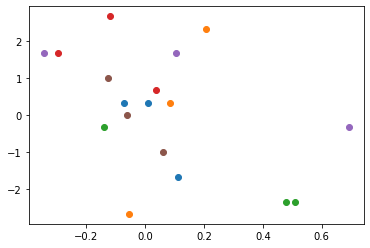

In [ ]:
fgi, ax = plt.subplots()
for pt in power_for_chan['ID'].unique():
    power_for_pt = power_for_chan[power_for_chan['ID'] == pt]
    X = power_for_pt[['GammaLow_log_chg']]
    Y = power_for_pt['Change_in_Memory']
    ax.scatter(X, Y)

In [ ]:
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf
from IPython.display import display

chan = 'RHip1 - RHip2'
power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
formula = "Change_in_Memory ~ "
for freq in freqs:
    formula += freq+"_log_chg + "
formula = formula[:-3]
model = smf.mixedlm(formula, power_for_chan, groups=power_for_chan['ID'])
result = model.fit()
print(chan+":")
display(result.summary())

## Correlations

In [ ]:
hip_chans = ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']

In [ ]:
freqs_short = freqs.copy()
freqs_short[-1] = 'G_XH'
freqs_short[-2] = 'G_H'
freqs_short[-3] = 'G_M'
freqs_short[-4] = 'G_L'

In [ ]:
from sklearn.linear_model import LinearRegression
def do_stats(power_and_mem, xlabel, ylabel, xlog=False, ylog=False):
    model = LinearRegression()

    fig, axs = plt.subplots(2, 2)
    fig.suptitle(f"{xlabel.replace('$FREQ', 'Power')} vs {ylabel.replace('$FREQ', 'Power')}")
    fig.set_size_inches(12, 8)

    for i, chan in enumerate(hip_chans):
        corrs = []
        power_for_chan = power_and_mem[power_and_mem['Channel'] == chan]
        for freq in freqs:
            xfeature = xlabel.replace('$FREQ', freq) if '$FREQ' in xlabel else xlabel
            yfeature = ylabel.replace('$FREQ', freq) if '$FREQ' in ylabel else ylabel
            X = power_for_chan[[xfeature]]
            if xlog:
                X = np.log10(X)
            Y = power_for_chan.eval(yfeature)
            if ylog:
                Y = np.log10(Y)
            model.fit(X, Y)
            corrs.append(model.score(X, Y))
            # print(f"{chan}, {freq}: r^2 = {corrs[-1]}")

        if '$FREQ' not in ylabel:
            X = pd.get_dummies(power_for_chan['ID'])
            Y = power_for_chan.eval(ylabel)
            if ylog:
                Y = np.log10(Y)
            model.fit(X, Y)
            corrs.append(model.score(X, Y))
        else:
            corrs.append(0)

        ind = np.arange(len(corrs))
        colors = ['tab:orange' for _ in corrs]
        colors[-1] = 'tab:blue'
        axs[i//2, i%2].bar(ind, corrs, color=colors)
        axs[i//2, i%2].set_xticks(ind, labels=[*freqs_short, 'ID'])
        axs[i//2, i%2].set_ylabel('$R^2$')
        axs[i//2, i%2].set_title(chan)
        axs[i//2, i%2].set_ylim(0, 1)

John said to start by seeing if PRE-stim power predicts POST-stim power. I made sure to take the log here since the powers can differ by orders of magnitude. Not taking the log results in only the strongest relationships showing up, but that might very well be skewed by one outlier patient

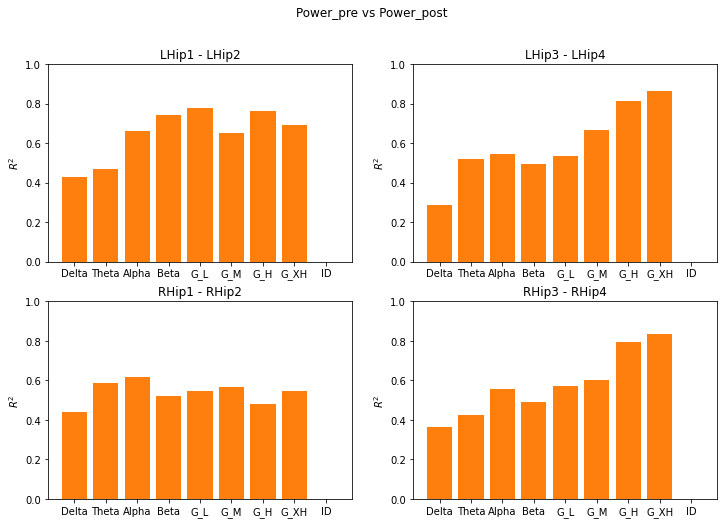

In [ ]:
do_stats(power_and_mem, '$FREQ_pre', '$FREQ_post', xlog=True, ylog=True)

In [ ]:
import statsmodels.formula.api as smf
from IPython.display import display

for freq in freqs:
    model = smf.ols(f"{freq}_post ~ {freq}_pre", power_and_mem)
    results = model.fit()
    display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Delta_post   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     34.07
Date:                Sun, 15 May 2022   Prob (F-statistic):           1.07e-08
Time:                        16:34:42   Log-Likelihood:                 5943.9
No. Observations:                 416   AIC:                        -1.188e+04
Df Residuals:                     414   BIC:                        -1.188e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.371e-08   8.39e-09      5.211      0.000    2.72e-08    6.02e-08
Delta_pre      0.6870      0.118      5.837      0.000       0.456       0.918
==============================================================================
Omnibus:                      611.810   Durbin-Watson:                   1.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           138956.888
Skew:                           7.610   Prob(JB):                         0.00
Kurtosis:                      91.233   Cond. No.                     1.59e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.65e-12. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Theta_post   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     79.41
Date:                Sun, 15 May 2022   Prob (F-statistic):           1.62e-17
Time:                        16:34:42   Log-Likelihood:                 6042.8
No. Observations:                 416   AIC:                        -1.208e+04
Df Residuals:                     414   BIC:                        -1.207e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.133e-08   6.56e-09      3.251      0.001    8.43e-09    3.42e-08
Theta_pre      0.8383      0.094      8.911      0.000       0.653       1.023
==============================================================================
Omnibus:                      600.824   Durbin-Watson:                   1.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            98453.478
Skew:                           7.515   Prob(JB):                         0.00
Kurtosis:                      76.852   Cond. No.                     1.61e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.61e-12. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Alpha_post   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     255.6
Date:                Sun, 15 May 2022   Prob (F-statistic):           3.71e-45
Time:                        16:34:42   Log-Likelihood:                 6425.1
No. Observations:                 416   AIC:                        -1.285e+04
Df Residuals:                     414   BIC:                        -1.284e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.722e-09   2.52e-09      3.064      0.002    2.77e-09    1.27e-08
Alpha_pre      0.9712      0.061     15.989      0.000       0.852       1.091
==============================================================================
Omnibus:                      455.191   Durbin-Watson:                   1.251
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23328.992
Skew:                           4.935   Prob(JB):                         0.00
Kurtosis:                      38.334   Cond. No.                     2.61e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.13e-13. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Beta_post   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     105.4
Date:                Sun, 15 May 2022   Prob (F-statistic):           3.47e-22
Time:                        16:34:42   Log-Likelihood:                 6928.7
No. Observations:                 416   AIC:                        -1.385e+04
Df Residuals:                     414   BIC:                        -1.385e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.945e-09   7.59e-10      3.883      0.000    1.45e-09    4.44e-09
Beta_pre       0.6936      0.068     10.268      0.000       0.561       0.826
==============================================================================
Omnibus:                      476.220   Durbin-Watson:                   1.205
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30441.935
Skew:                           5.232   Prob(JB):                         0.00
Kurtosis:                      43.581   Cond. No.                     9.72e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.4e-14. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          GammaLow_post   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     118.4
Date:                Sun, 15 May 2022   Prob (F-statistic):           2.02e-24
Time:                        16:34:43   Log-Likelihood:                 8085.3
No. Observations:                 416   AIC:                        -1.617e+04
Df Residuals:                     414   BIC:                        -1.616e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.378e-10   5.28e-11      2.608      0.009    3.39e-11    2.42e-10
GammaLow_pre     0.8768      0.081     10.881      0.000       0.718       1.035
==============================================================================
Omnibus:                      576.584   Durbin-Watson:                   1.426
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            74696.471
Skew:                           7.051   Prob(JB):                         0.00
Kurtosis:                      67.113   Cond. No.                     1.87e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.19e-16. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          GammaMed_post   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     65.11
Date:                Sun, 15 May 2022   Prob (F-statistic):           7.76e-15
Time:                        16:34:43   Log-Likelihood:                 8510.7
No. Observations:                 416   AIC:                        -1.702e+04
Df Residuals:                     414   BIC:                        -1.701e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.462e-11   2.08e-11      0.703      0.483   -2.63e-11    5.55e-11
GammaMed_pre     1.2220      0.151      8.069      0.000       0.924       1.520
==============================================================================
Omnibus:                      774.595   Durbin-Watson:                   1.413
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           564970.259
Skew:                          11.754   Prob(JB):                         0.00
Kurtosis:                     182.002   Cond. No.                     9.77e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.36e-18. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         GammaHigh_post   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     42.41
Date:                Sun, 15 May 2022   Prob (F-statistic):           2.15e-10
Time:                        16:34:43   Log-Likelihood:                 8683.3
No. Observations:                 416   AIC:                        -1.736e+04
Df Residuals:                     414   BIC:                        -1.735e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.152e-12   1.51e-11     -0.076      0.939   -3.09e-11    2.85e-11
GammaHigh_pre     1.6027      0.246      6.512      0.000       1.119       2.086
==============================================================================
Omnibus:                      794.173   Durbin-Watson:                   1.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           567850.876
Skew:                          12.452   Prob(JB):                         0.00
Kurtosis:                     182.277   Cond. No.                     2.40e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.2e-19. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        GammaXHigh_post   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     42.41
Date:                Sun, 15 May 2022   Prob (F-statistic):           2.15e-10
Time:                        16:34:43   Log-Likelihood:                 8966.3
No. Observations:                 416   AIC:                        -1.793e+04
Df Residuals:                     414   BIC:                        -1.792e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.226e-12   7.67e-12      0.160      0.873   -1.39e-11    1.63e-11
GammaXHigh_pre     1.4899      0.229      6.512      0.000       1.040       1.940
==============================================================================
Omnibus:                      841.950   Durbin-Watson:                   1.359
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           921473.826
Skew:                          13.955   Prob(JB):                         0.00
Kurtosis:                     231.873   Cond. No.                     4.41e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.14e-19. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

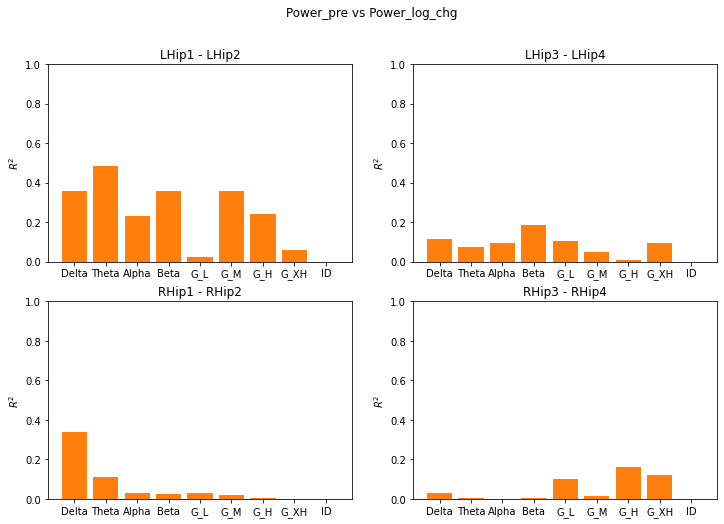

In [ ]:
do_stats(power_and_mem, '$FREQ_pre', '$FREQ_log_chg', xlog=True)

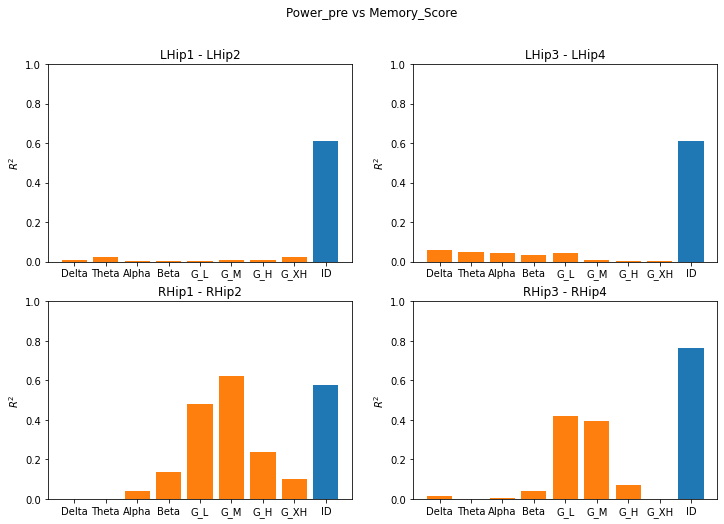

In [ ]:
do_stats(power_and_mem, '$FREQ_pre', 'Memory_Score', xlog=True)

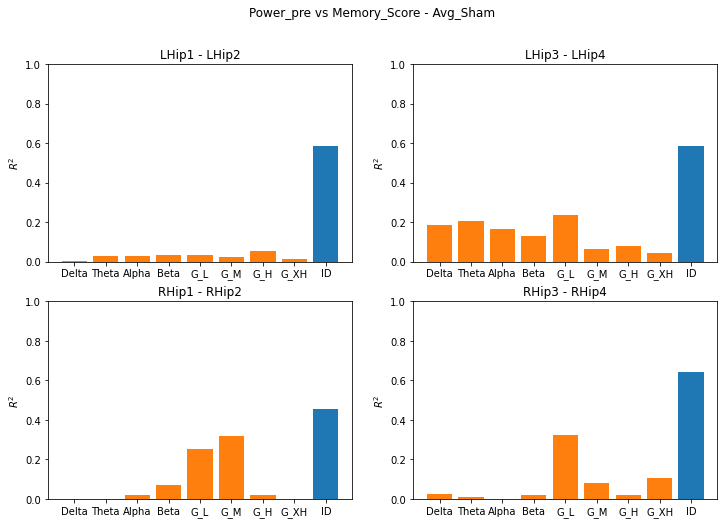

In [ ]:
do_stats(power_and_mem, '$FREQ_pre', 'Memory_Score - Avg_Sham', xlog=True)

In [ ]:
power_and_mem['Change_in_Memory'] = power_and_mem['Memory_Score'] - power_and_mem['Avg_Sham']

In [ ]:
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf
from IPython.display import display

for chan in hip_chans:
    power_for_chan = power_and_mem[power_and_mem['Channel'] == chan]
    formula = "Change_in_Memory ~ "
    for freq in freqs:
        formula += "np.log10("+freq+"_post) + "
    formula = formula[:-3]
    model = smf.mixedlm(formula, power_for_chan, groups=power_for_chan['ID'])
    result = model.fit()
    print(chan+":")
    display(result.summary())

LHip1 - LHip2:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:               MixedLM   Dependent Variable:   Change_in_Memory
No. Observations:    70        Method:               REML            
No. Groups:          6         Scale:                1.5978          
Min. group size:     11        Log-Likelihood:       -111.3050       
Max. group size:     12        Converged:            Yes             
Mean group size:     11.7                                            
---------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------
Intercept                 -2.317   19.633 -0.118 0.906 -40.797 36.163
np.log10(Delta_post)      -0.430    1.104 -0.390 0.697  -2.594  1.734
np.log10(Theta_post)      -0.159    1.406 -0.113 0.910  -2.915  2.598
np.log10(Alpha_post)       0.020    1.347  0.015 0.988  -2.620  2.659
np.log10(Beta_post)        0.997    1.316  0.758 0.449  -1.581  3.575
np.log10(GammaLow_post)    0.689    1.343  0.513 0.608  -1.943  3.322
np.log10(GammaMed_post)    0.587    1.348  0.436 0.663  -2.054  3.229
np.log10(GammaHigh_post)  -2.527    1.871 -1.351 0.177  -6.193  1.140
np.log10(GammaXHigh_post)  0.688    1.625  0.424 0.672  -2.497  3.873
Group Var                  2.651    1.764                            
=====================================================================

"""

LHip3 - LHip4:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:               MixedLM   Dependent Variable:   Change_in_Memory
No. Observations:    70        Method:               REML            
No. Groups:          6         Scale:                1.4835          
Min. group size:     11        Log-Likelihood:       -107.5462       
Max. group size:     12        Converged:            Yes             
Mean group size:     11.7                                            
---------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------
Intercept                 -7.435   10.777 -0.690 0.490 -28.558 13.688
np.log10(Delta_post)      -1.752    0.791 -2.216 0.027  -3.301 -0.202
np.log10(Theta_post)      -0.841    1.042 -0.807 0.420  -2.883  1.202
np.log10(Alpha_post)       0.330    1.045  0.316 0.752  -1.718  2.378
np.log10(Beta_post)        0.538    1.052  0.511 0.609  -1.524  2.600
np.log10(GammaLow_post)    0.020    1.199  0.017 0.987  -2.330  2.370
np.log10(GammaMed_post)    0.387    1.203  0.322 0.748  -1.970  2.744
np.log10(GammaHigh_post)  -0.190    1.336 -0.142 0.887  -2.808  2.428
np.log10(GammaXHigh_post)  0.276    1.479  0.187 0.852  -2.622  3.174
Group Var                  0.563    0.710                            
=====================================================================

"""

RHip1 - RHip2:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:               MixedLM   Dependent Variable:   Change_in_Memory
No. Observations:    70        Method:               REML            
No. Groups:          6         Scale:                1.5117          
Min. group size:     11        Log-Likelihood:       -111.7647       
Max. group size:     12        Converged:            Yes             
Mean group size:     11.7                                            
---------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------
Intercept                 -4.139    7.268 -0.570 0.569 -18.385 10.106
np.log10(Delta_post)       0.116    0.831  0.140 0.889  -1.513  1.745
np.log10(Theta_post)      -0.127    1.225 -0.103 0.918  -2.527  2.274
np.log10(Alpha_post)      -0.040    1.216 -0.032 0.974  -2.424  2.344
np.log10(Beta_post)        1.460    1.256  1.163 0.245  -1.001  3.921
np.log10(GammaLow_post)   -1.859    0.995 -1.869 0.062  -3.809  0.091
np.log10(GammaMed_post)    0.228    1.088  0.210 0.834  -1.905  2.361
np.log10(GammaHigh_post)   0.395    1.225  0.323 0.747  -2.006  2.797
np.log10(GammaXHigh_post) -0.471    1.233 -0.382 0.702  -2.888  1.946
Group Var                  1.985    1.267                            
=====================================================================

"""

RHip3 - RHip4:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:               MixedLM   Dependent Variable:   Change_in_Memory
No. Observations:    58        Method:               REML            
No. Groups:          5         Scale:                0.8043          
Min. group size:     11        Log-Likelihood:       -75.6282        
Max. group size:     12        Converged:            Yes             
Mean group size:     11.6                                            
---------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------
Intercept                 -8.932    8.486 -1.053 0.293 -25.564  7.699
np.log10(Delta_post)       0.091    0.918  0.099 0.921  -1.708  1.889
np.log10(Theta_post)      -0.510    1.089 -0.468 0.640  -2.645  1.626
np.log10(Alpha_post)       1.101    0.833  1.321 0.186  -0.532  2.734
np.log10(Beta_post)       -0.479    0.669 -0.716 0.474  -1.790  0.832
np.log10(GammaLow_post)   -1.639    0.817 -2.005 0.045  -3.241 -0.037
np.log10(GammaMed_post)    1.305    1.188  1.099 0.272  -1.023  3.633
np.log10(GammaHigh_post)  -1.193    1.312 -0.909 0.363  -3.765  1.379
np.log10(GammaXHigh_post)  0.382    0.946  0.404 0.686  -1.472  2.236
Group Var                  3.149    2.860                            
=====================================================================

"""

In [ ]:
result.t_test(np.identity(len(result.params) - 1), use_t=True)

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -8.9324      8.486     -1.053      0.298     -25.985       8.120
c1             0.0394      0.398      0.099      0.922      -0.761       0.840
c2            -0.2214      0.473     -0.468      0.642      -1.172       0.729
c3             0.4781      0.362      1.321      0.193      -0.249       1.205
c4            -0.2080      0.290     -0.716      0.477      -0.792       0.376
c5            -0.7118      0.355     -2.005      0.050      -1.425       0.002
c6             0.5667      0.516      1.099      0.277      -0.470       1.603
c7            -0.5181      0.570     -0.909      0.368      -1.664       0.627
c8             0.1658      0.411      0.404      0.688      -0.660       0.991

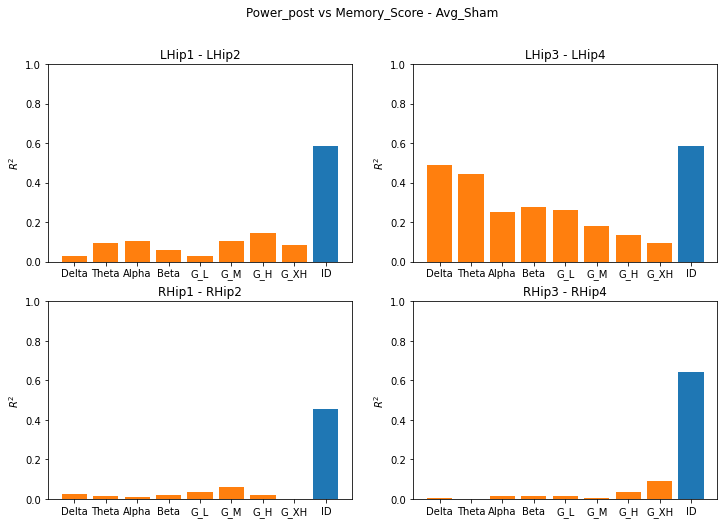

In [ ]:
do_stats(power_and_mem, '$FREQ_post', 'Memory_Score - Avg_Sham', xlog=True)

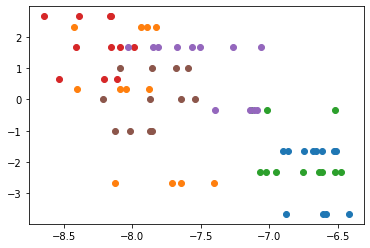

In [ ]:
fig, ax = plt.subplots()
power_for_chan = power_and_mem[power_and_mem['Channel'] == 'LHip3 - LHip4']
for i, pt in enumerate(power_for_chan['ID'].unique()):
    power_for_pt = power_for_chan[power_for_chan['ID'] == pt]
    ax.scatter(np.log10(power_for_pt['Delta_post']), power_for_pt['Change_in_Memory'])

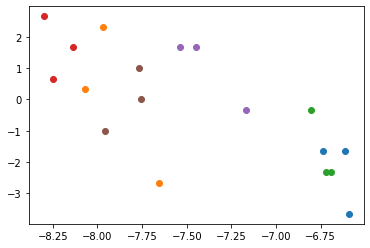

In [ ]:
df_averaged = pd.DataFrame()
for freq in freqs:
    x_for_freq = '$FREQ_post'.replace('$FREQ', freq)
    df_averaged[x_for_freq] = power_and_mem.groupby(['ID', 'Trial', 'Channel']).apply(lambda g: g.eval(x_for_freq)).groupby(['ID', 'Trial', 'Channel']).mean()
df_mems = power_and_mem.groupby(['ID', 'Trial', 'Channel']).mean()
for col in df_mems.columns:
    if col in ['Memory_Score', 'Avg_Sham', 'Change_in_Memory']:
        df_averaged[col] = df_mems[col]
df_averaged = df_averaged.reset_index()

fig, ax = plt.subplots()
power_for_chan = df_averaged[df_averaged['Channel'] == 'LHip3 - LHip4']
for i, pt in enumerate(power_for_chan['ID'].unique()):
    power_for_pt = power_for_chan[power_for_chan['ID'] == pt]
    ax.scatter(np.log10(power_for_pt['Delta_post']), power_for_pt['Memory_Score'] - power_for_pt['Avg_Sham'])

In [ ]:
df_averaged = pd.DataFrame()
for freq in freqs:
    x_for_freq = '$FREQ_post'.replace('$FREQ', freq)
    df_averaged[x_for_freq] = power_and_mem.groupby(['ID', 'Trial', 'Channel']).apply(lambda g: g.eval(x_for_freq)).groupby(['ID', 'Trial', 'Channel']).mean()
df_mems = power_and_mem.groupby(['ID', 'Trial', 'Channel']).mean()
for col in df_mems.columns:
    if col in ['Memory_Score', 'Avg_Sham', 'Change_in_Memory']:
        df_averaged[col] = df_mems[col]
df_averaged = df_averaged.reset_index()

In [ ]:
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf
from IPython.display import display

for chan in hip_chans:
    power_for_chan = df_averaged[df_averaged['Channel'] == chan]
    formula = "Change_in_Memory ~ "
    for freq in freqs:
        formula += "np.log10("+freq+"_post) + "
    formula = formula[:-3]
    model = smf.mixedlm(formula, power_for_chan, groups=power_for_chan['ID'])
    result = model.fit()
    print(chan+":")
    display(result.summary())

LHip1 - LHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:                MixedLM   Dependent Variable:   Change_in_Memory
No. Observations:     18        Method:               REML            
No. Groups:           6         Scale:                2.6450          
Min. group size:      3         Log-Likelihood:       -12.2662        
Max. group size:      3         Converged:            Yes             
Mean group size:      3.0                                             
----------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------------------
Intercept                  -9.117   31.693 -0.288 0.774 -71.233 53.000
np.log10(Delta_post)        0.215    4.527  0.048 0.962  -8.657  9.087
np.log10(Theta_post)        4.931    9.657  0.511 0.610 -13.996 23.858
np.log10(Alpha_post)      -12.896   11.908 -1.083 0.279 -36.235 10.443
np.log10(Beta_post)        12.920   11.651  1.109 0.267  -9.916 35.756
np.log10(GammaLow_post)     2.503   10.078  0.248 0.804 -17.249 22.255
np.log10(GammaMed_post)     6.502    9.687  0.671 0.502 -12.483 25.488
np.log10(GammaHigh_post)  -25.448   15.072 -1.688 0.091 -54.989  4.094
np.log10(GammaXHigh_post)  11.144    7.928  1.406 0.160  -4.394 26.682
Group Var                   0.000    1.992                            
======================================================================

"""

LHip3 - LHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:               MixedLM   Dependent Variable:   Change_in_Memory
No. Observations:    18        Method:               REML            
No. Groups:          6         Scale:                1.5868          
Min. group size:     3         Log-Likelihood:       -12.0567        
Max. group size:     3         Converged:            Yes             
Mean group size:     3.0                                             
---------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------
Intercept                 -8.573   22.903 -0.374 0.708 -53.461 36.316
np.log10(Delta_post)      -2.694    2.597 -1.037 0.300  -7.783  2.395
np.log10(Theta_post)      -2.820    2.735 -1.031 0.303  -8.181  2.541
np.log10(Alpha_post)      -0.717    4.855 -0.148 0.883 -10.232  8.797
np.log10(Beta_post)        4.325    7.707  0.561 0.575 -10.779 19.430
np.log10(GammaLow_post)   -1.838    4.613 -0.398 0.690 -10.879  7.203
np.log10(GammaMed_post)   -2.015    8.776 -0.230 0.818 -19.217 15.186
np.log10(GammaHigh_post)   6.961   11.174  0.623 0.533 -14.940 28.861
np.log10(GammaXHigh_post) -3.053    6.899 -0.443 0.658 -16.574 10.467
Group Var                  0.000    1.963                            
=====================================================================

"""

c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


RHip1 - RHip2:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:               MixedLM   Dependent Variable:   Change_in_Memory
No. Observations:    18        Method:               REML            
No. Groups:          6         Scale:                2.9046          
Min. group size:     3         Log-Likelihood:       -16.3756        
Max. group size:     3         Converged:            Yes             
Mean group size:     3.0                                             
---------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------
Intercept                 -6.016   14.017 -0.429 0.668 -33.488 21.457
np.log10(Delta_post)       0.187    3.299  0.057 0.955  -6.279  6.653
np.log10(Theta_post)       1.569    6.568  0.239 0.811 -11.303 14.442
np.log10(Alpha_post)      -4.410    5.743 -0.768 0.443 -15.665  6.846
np.log10(Beta_post)        5.664    5.276  1.074 0.283  -4.676 16.005
np.log10(GammaLow_post)   -8.543    6.932 -1.232 0.218 -22.129  5.043
np.log10(GammaMed_post)    7.329    4.900  1.496 0.135  -2.276 16.933
np.log10(GammaHigh_post)   1.995    4.883  0.409 0.683  -7.576 11.566
np.log10(GammaXHigh_post) -4.306    4.403 -0.978 0.328 -12.935  4.324
Group Var                  0.022                                     
=====================================================================

"""

RHip3 - RHip4:


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:               MixedLM    Dependent Variable:    Change_in_Memory
No. Observations:    15         Method:                REML            
No. Groups:          5          Scale:                 1.3627          
Min. group size:     3          Log-Likelihood:        -6.8345         
Max. group size:     3          Converged:             Yes             
Mean group size:     3.0                                               
-----------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------
Intercept                 -24.751   61.484 -0.403 0.687 -145.256 95.755
np.log10(Delta_post)        2.185    8.861  0.247 0.805  -15.182 19.551
np.log10(Theta_post)       -3.971   11.776 -0.337 0.736  -27.051 19.109
np.log10(Alpha_post)        5.952    5.722  1.040 0.298   -5.262 17.166
np.log10(Beta_post)        -2.213    5.298 -0.418 0.676  -12.597  8.171
np.log10(GammaLow_post)    -3.132    3.542 -0.884 0.377  -10.074  3.810
np.log10(GammaMed_post)     2.577   14.911  0.173 0.863  -26.648 31.802
np.log10(GammaHigh_post)   -2.425   12.398 -0.196 0.845  -26.726 21.875
np.log10(GammaXHigh_post)  -1.068    6.833 -0.156 0.876  -14.459 12.324
Group Var                   7.688   11.843                             
=======================================================================

"""

In [ ]:
from typing import Literal
def mixed_effects_stats(power_and_mem, x, y, xlabel=None, ylabel=None, baselines_only=False,
    mem_null_hyp=0, show_all_p=False, linreg_pval: Literal['t', 'perm', 'kendall']='t',
    force_avg: Literal['full', 'partial', 'stim', None] =None,
    freqs = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
    ):
    if xlabel is None:
        xlabel = x
    if ylabel is None:
        ylabel = y

    df = power_and_mem
    if baselines_only:
        df = power_and_mem.drop_duplicates(subset=['ID', 'Trial', 'Channel'])

    # if you're looking at short-term memory, which is measured after each trial,
    # per-stim analyses are invalid. Aggregate df and group by trial to get meaningful results
    x_evald = False
    if force_avg == 'full' or 'Delay_Mem_Stim' in y:
        print('Averaging across stims and trials in the same patient and channel')
        df_averaged = pd.DataFrame()
        if '$FREQ' in x:
            for freq in freqs:
                x_for_freq = x.replace('$FREQ', freq)
                df_averaged[x_for_freq] = df.groupby(['ID', 'Channel']).apply(lambda g: g.eval(x_for_freq)).groupby(['ID', 'Channel']).mean()
        df_mems = df.groupby(['ID', 'Channel']).mean()
        for col in df_mems.columns:
            if col in y:
                df_averaged[col] = df_mems[col]
        df = df_averaged.reset_index()
        # we need to set this true so that we don't evaluate the function of x again later (e.g. log(log(x)))
        x_evald = True
    elif force_avg == 'partial' or 'Memory_Score' in y:
        print('Averaging across stims in the same patient, channel, and trial')
        df_averaged = pd.DataFrame()
        if '$FREQ' in x:
            for freq in freqs:
                x_for_freq = x.replace('$FREQ', freq)
                df_averaged[freq] = df.groupby(['ID', 'Trial', 'Channel']).apply(lambda g: g.eval(x_for_freq)).groupby(['ID', 'Trial', 'Channel']).mean()
        df_mems = df.groupby(['ID', 'Trial', 'Channel']).mean()
        for col in df_mems.columns:
            if col in y:
                df_averaged[col] = df_mems[col]
        df = df_averaged.reset_index()
        # we need to set this true so that we don't evaluate the function of x again later (e.g. log(log(x)))
        x_evald = True
    elif force_avg == 'stim':
        print('Averaging across trials in the same patient, channel, and stim')
        df_averaged = pd.DataFrame()
        if '$FREQ' in x:
            for freq in freqs:
                x_for_freq = x.replace('$FREQ', freq)
                df_averaged[x_for_freq] = df.groupby(['ID', 'Stim_Num', 'Channel']).apply(lambda g: g.eval(x_for_freq)).groupby(['ID', 'Stim_Num', 'Channel']).mean()
        df_mems = df.groupby(['ID', 'Stim_Num', 'Channel']).mean()
        for col in df_mems.columns:
            if col in y:
                df_averaged[col] = df_mems[col]
        df = df_averaged.reset_index()
        # we need to set this true so that we don't evaluate the function of x again later (e.g. log(log(x)))
        x_evald = True

    num_cols = len(freqs) // 2 + 1
    hist_fig, hist_ax = plt.subplots(2, num_cols)
    hist_fig.set_size_inches(10, 8)

    fig, ax = plt.subplots(2, num_cols)
    fig.set_size_inches(12, 8)
    for i in range(len(freqs)):
        freq = freqs[i]
        xs = df[freq] if x_evald else df.eval(x.replace('$FREQ', freq))
        ys = df.eval(y)
        ax[i//num_cols, i%num_cols].scatter(xs, ys)
        ax[i//num_cols, i%num_cols].set_title(freq)

        hist_ax[i//num_cols, i%num_cols].hist(xs)
        hist_ax[i//num_cols, i%num_cols].set_title(freq)

    hist_ax[1, num_cols-1].hist(ys)
    hist_ax[1, num_cols-1].set_title(ylabel)

    if y == 'Memory_Score - Avg_Sham':
        df['Change_in_Memory'] = df['Memory_Score'] - df['Avg_Sham']

    temp_stats = []
    temp_chi = []

    for chan in hip_chans:
        fig, ax = plt.subplots(2, num_cols)
        fig.set_size_inches(14, 10)
        fig.suptitle(chan)
        power_for_chan = df[df['Channel'] == chan]
        for i in range(len(freqs)):
            freq = freqs[i]
            for pt_id in power_for_chan['ID'].unique():
                power_for_pt = power_for_chan[power_for_chan['ID'] == pt_id]
                xs = power_for_pt[freq] if x_evald else power_for_pt.eval(x.replace('$FREQ', freq))
                ys = power_for_pt.eval(y)
                ax[i//num_cols, i%num_cols].scatter(xs, ys)
            ax[i//num_cols, i%num_cols].set_title(freq)
            ax[i//num_cols, i%num_cols].set_xlabel(xlabel)
            ax[i//num_cols, i%num_cols].set_ylabel(ylabel)

            xs = power_for_chan[freq] if x_evald else power_for_chan.eval(x.replace('$FREQ', freq))
            ys = power_for_chan.eval(y)
            result = scipy.stats.linregress(xs, ys)
            line_x = np.array([xs.min(), xs.max()])
            ax[i//num_cols, i%num_cols].plot(line_x, result.slope * line_x + result.intercept, linestyle='--')

            # Ran into a problem with chi square because I have very low counts, switching to Fisher's exact
            # reuqires 2-way table, so no change was dropped. idk if that is legal tho
            inc_pow = xs > 0
            dec_pow = xs < 0
            inc_mem = power_for_chan.eval(y) > mem_null_hyp
            # nc_mem = power_for_chan.eval(y) == 0
            dec_mem = power_for_chan.eval(y) < mem_null_hyp
            crosstab = pd.DataFrame([
                [len(power_for_chan[dec_pow & dec_mem]), len(power_for_chan[inc_pow & dec_mem])],
                # [len(power_for_chan[dec_pow & nc_mem]), len(power_for_chan[inc_pow & nc_mem])],
                [len(power_for_chan[dec_pow & inc_mem]), len(power_for_chan[inc_pow & inc_mem])],
            ])
            crosstab.columns = pd.MultiIndex.from_tuples([('Power', 'Decrease'), ('Power', 'Increase')])
            # crosstab.index = pd.MultiIndex.from_tuples([('Memory', 'Decrease'), ('Memory', 'No Change'), ('Memory', 'Increase')])
            crosstab.index = pd.MultiIndex.from_tuples([('Memory', 'Decrease'), ('Memory', 'Increase')])
            chi_sq_p = scipy.stats.fisher_exact(crosstab)[1]
            temp_chi.append({'Channel': chan, 'Frequency': freq, 'P':chi_sq_p})
            if chi_sq_p < 0.50: # TODO reset threshold
                print(f'Fisher Exact P-value = {chi_sq_p} for {freq} band in {chan}')
                display(crosstab)
        
        
        formula = "Change_in_Memory ~ "
        for freq in freqs:
            formula += freq + " + "
        formula = formula[:-3] # removes the last  " + "
        print(power_for_chan.columns)
        model = smf.mixedlm(formula, power_for_chan, groups=power_for_chan['ID'])
        result = model.fit()
        print(chan+":")
        display(result.summary())

Averaging across stims in the same patient, channel, and trial
Index(['ID', 'Trial', 'Channel', 'Delta', 'Theta', 'Alpha', 'Beta', 'GammaLow',
       'GammaMed', 'GammaHigh', 'GammaXHigh', 'Avg_Sham', 'Memory_Score',
       'Change_in_Memory'],
      dtype='object')


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


LHip1 - LHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2705: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: Change_in_Memory
No. Observations: 18      Method:             REML            
No. Groups:       6       Scale:              2.1981          
Min. group size:  3       Log-Likelihood:     -29.7337        
Max. group size:  3       Converged:          Yes             
Mean group size:  3.0                                         
---------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------
Intercept      11.585    32.992   0.351  0.725  -53.077  76.248
Delta          -0.035                                          
Theta           0.820     0.447   1.833  0.067   -0.057   1.696
Alpha          -1.427     0.388  -3.675  0.000   -2.189  -0.666
Beta            0.920     0.724   1.271  0.204   -0.499   2.339
GammaLow        0.529     0.389   1.361  0.174   -0.233   1.292
GammaMed        0.863     1.028   0.840  0.401   -1.152   2.879
GammaHigh      -3.051     0.993  -3.074  0.002   -4.996  -1.106
GammaXHigh      1.555     0.662   2.350  0.019    0.258   2.852
Group Var       0.008                                          
==============================================================

"""

Index(['ID', 'Trial', 'Channel', 'Delta', 'Theta', 'Alpha', 'Beta', 'GammaLow',
       'GammaMed', 'GammaHigh', 'GammaXHigh', 'Avg_Sham', 'Memory_Score',
       'Change_in_Memory'],
      dtype='object')


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


LHip3 - LHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.066841
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: Change_in_Memory
No. Observations: 18      Method:             REML            
No. Groups:       6       Scale:              1.6556          
Min. group size:  3       Log-Likelihood:     -30.2836        
Max. group size:  3       Converged:          No              
Mean group size:  3.0                                         
---------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------
Intercept      -1.425    23.575  -0.060  0.952  -47.631  44.782
Delta          -0.361     0.451  -0.799  0.424   -1.245   0.524
Theta          -0.217     0.375  -0.579  0.563   -0.951   0.517
Alpha          -0.108     0.686  -0.158  0.875   -1.454   1.237
Beta            0.426     1.296   0.329  0.742   -2.113   2.966
GammaLow        0.008     0.549   0.014  0.989   -1.069   1.084
GammaMed       -0.244     1.420  -0.172  0.863   -3.028   2.539
GammaHigh       0.642     1.821   0.352  0.725   -2.927   4.211
GammaXHigh     -0.266     1.150  -0.231  0.817   -2.521   1.988
Group Var       0.017     4.459                                
==============================================================

"""

Index(['ID', 'Trial', 'Channel', 'Delta', 'Theta', 'Alpha', 'Beta', 'GammaLow',
       'GammaMed', 'GammaHigh', 'GammaXHigh', 'Avg_Sham', 'Memory_Score',
       'Change_in_Memory'],
      dtype='object')
RHip1 - RHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: Change_in_Memory
No. Observations: 18      Method:             REML            
No. Groups:       6       Scale:              2.2362          
Min. group size:  3       Log-Likelihood:     -32.8402        
Max. group size:  3       Converged:          Yes             
Mean group size:  3.0                                         
---------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------
Intercept     -10.087    13.719  -0.735  0.462  -36.975  16.802
Delta           0.125     0.155   0.809  0.419   -0.178   0.429
Theta          -0.244     0.600  -0.406  0.685   -1.420   0.933
Alpha          -0.233     0.770  -0.302  0.763   -1.742   1.277
Beta            0.913     0.684   1.334  0.182   -0.428   2.255
GammaLow       -1.236     0.556  -2.222  0.026   -2.326  -0.146
GammaMed        0.809     0.386   2.096  0.036    0.053   1.566
GammaHigh       0.577     0.641   0.901  0.368   -0.678   1.833
GammaXHigh     -0.789     0.443  -1.783  0.075   -1.656   0.078
Group Var       0.000                                          
==============================================================

"""

Index(['ID', 'Trial', 'Channel', 'Delta', 'Theta', 'Alpha', 'Beta', 'GammaLow',
       'GammaMed', 'GammaHigh', 'GammaXHigh', 'Avg_Sham', 'Memory_Score',
       'Change_in_Memory'],
      dtype='object')
RHip3 - RHip4:


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: Change_in_Memory
No. Observations: 15      Method:             REML            
No. Groups:       5       Scale:              0.9581          
Min. group size:  3       Log-Likelihood:     -23.9018        
Max. group size:  3       Converged:          Yes             
Mean group size:  3.0                                         
---------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|   [0.025    0.975]
---------------------------------------------------------------
Intercept   -52.073    99.955  -0.521  0.602  -247.980  143.835
Delta         0.096     0.887   0.108  0.914    -1.643    1.835
Theta        -0.331     0.866  -0.382  0.702    -2.027    1.366
Alpha         0.830     0.662   1.253  0.210    -0.468    2.127
Beta         -0.106     0.554  -0.191  0.849    -1.192    0.981
GammaLow     -0.589     0.518  -1.138  0.255    -1.603    0.426
GammaMed     -0.090     2.043  -0.044  0.965    -4.095    3.915
GammaHigh     0.220     2.412   0.091  0.927    -4.508    4.947
GammaXHigh   -0.472     1.639  -0.288  0.773    -3.685    2.740
Group Var    11.058    19.660                                  
==============================================================

"""

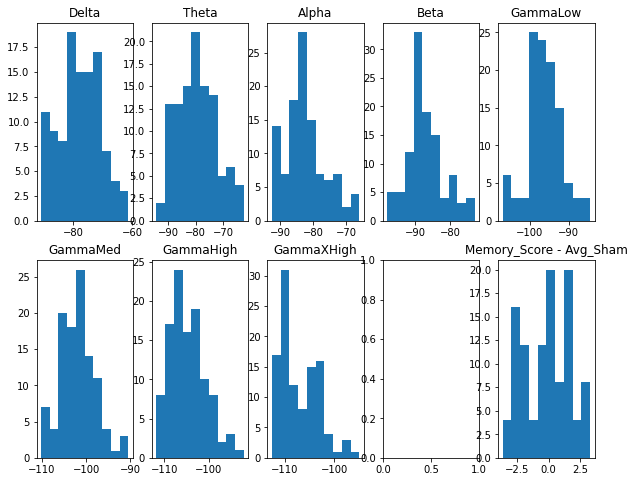

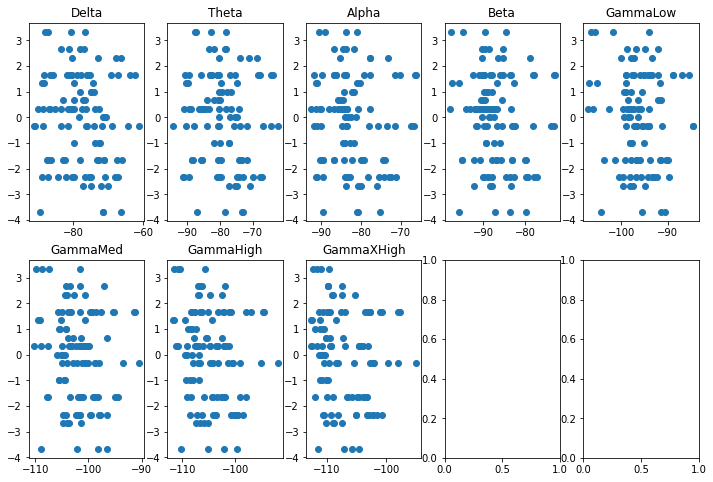

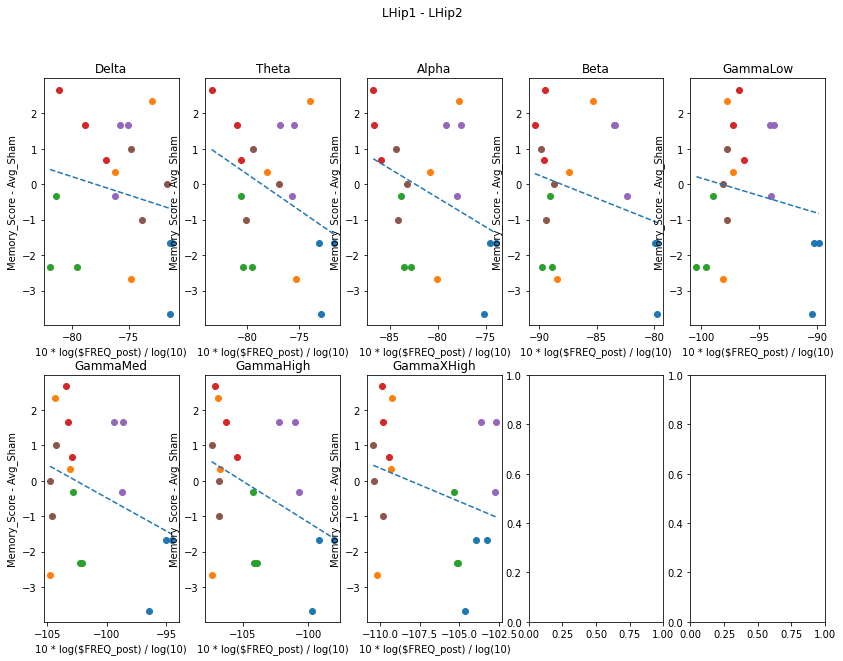

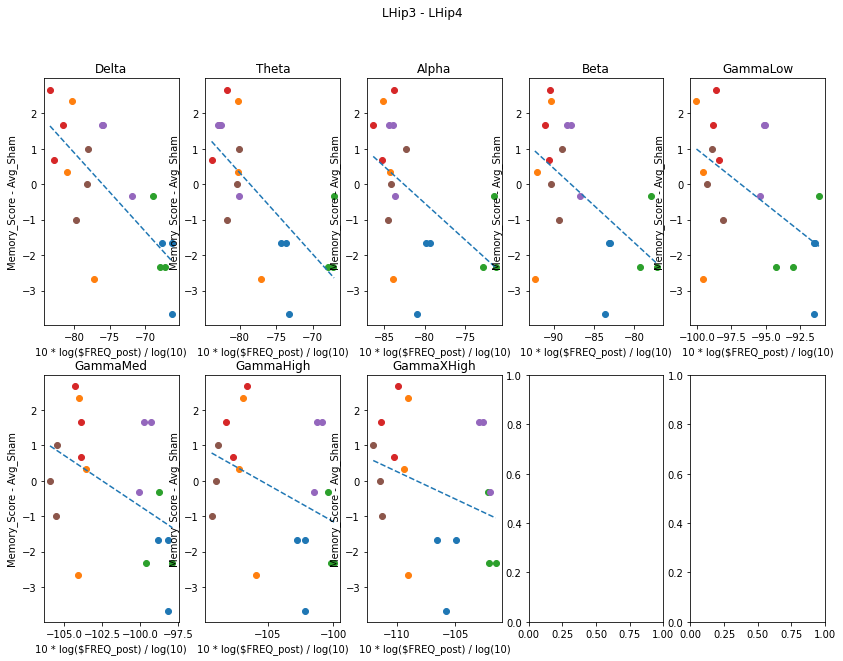

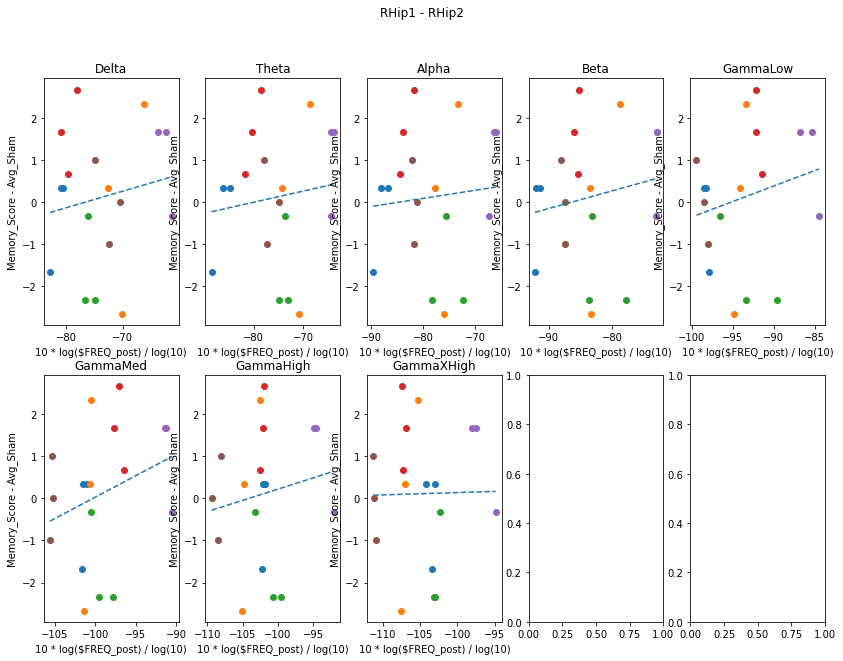

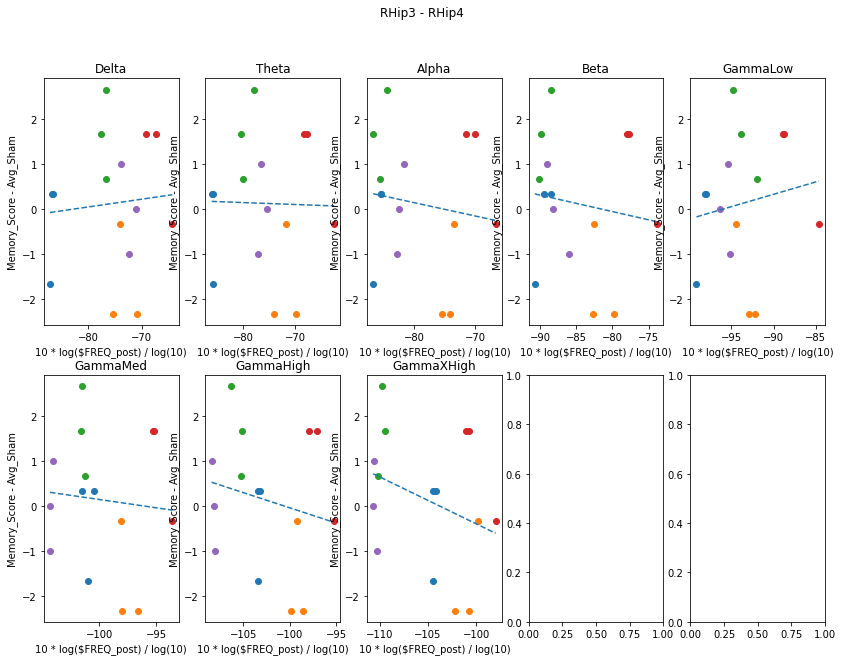

In [ ]:
mixed_effects_stats(power_and_mem, '10 * log($FREQ_post) / log(10)', 'Memory_Score - Avg_Sham', freqs=freqs, force_avg='partial')

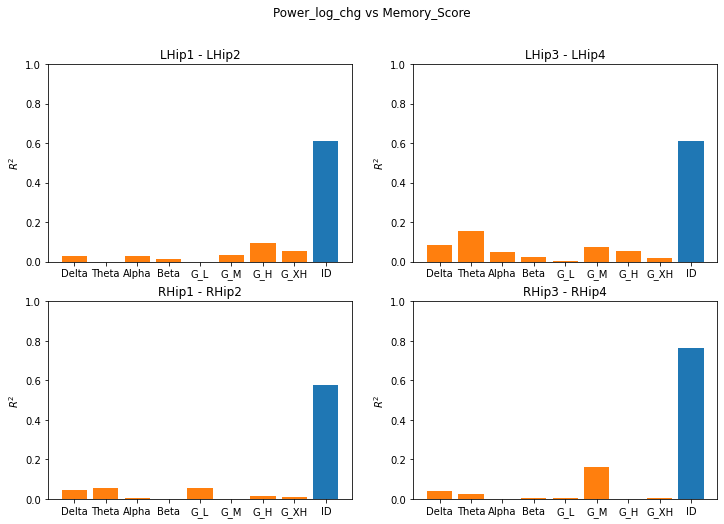

In [ ]:
do_stats(power_and_mem, '$FREQ_log_chg', 'Memory_Score')

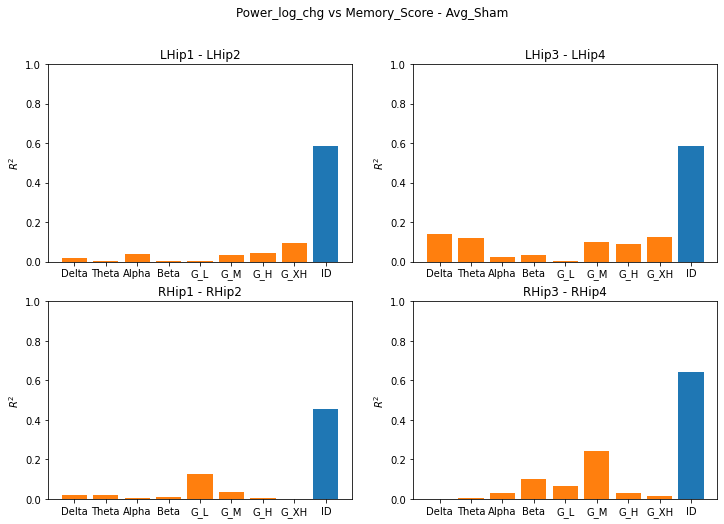

In [ ]:
do_stats(power_and_mem, '$FREQ_log_chg', 'Memory_Score - Avg_Sham')

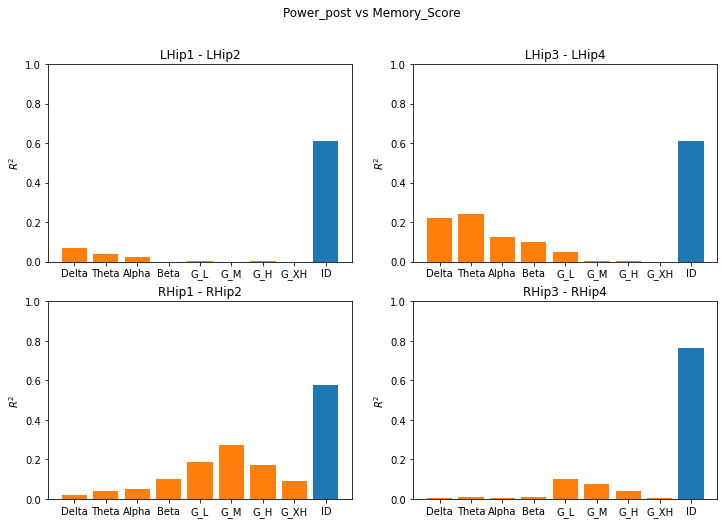

In [ ]:
do_stats(power_and_mem, '$FREQ_post', 'Memory_Score', xlog=True)

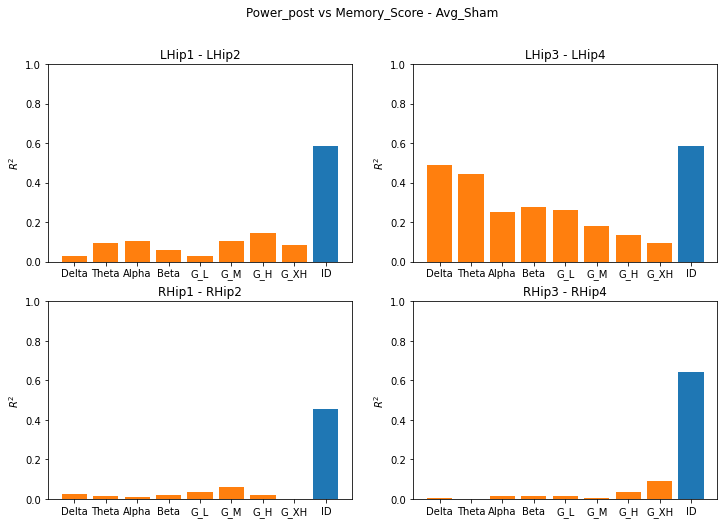

In [ ]:
do_stats(power_and_mem, '$FREQ_post', 'Memory_Score - Avg_Sham', xlog=True)

In [ ]:
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
model = LinearRegression()
def bar_and_test(power_and_mem, xlabel, ylabel, xlog=False, ylog=False):
    fig, axs = plt.subplots(2, 2)
    fig.suptitle(f"{xlabel.replace('$FREQ', 'Power')} vs {ylabel.replace('$FREQ', 'Power')}")
    fig.set_size_inches(12, 8)

    for i, chan in enumerate(hip_chans):
        corrs = []
        power_for_chan = power_and_mem[power_and_mem['Channel'] == chan]
        for freq in freqs:
            xfeature = xlabel.replace('$FREQ', freq) if '$FREQ' in xlabel else xlabel
            yfeature = ylabel.replace('$FREQ', freq) if '$FREQ' in ylabel else ylabel
            X = power_for_chan[xfeature]
            if xlog:
                X = np.log10(X)
            Y = power_for_chan.eval(yfeature)
            if ylog:
                Y = np.log10(Y)
            result = linregress(X, Y)
            print(f"{chan}, {freq}: P = {result.pvalue}")

        if '$FREQ' not in ylabel:
            X = pd.get_dummies(power_for_chan['ID'])
            Y = power_for_chan.eval(ylabel)
            if ylog:
                Y = np.log10(Y)
            result = linregress(X, Y)
            print(f"{chan}, ID: P = {result.pvalue}, R^2 = {result.rvalue ** 2}")
        else:
            corrs.append(0)

        ind = np.arange(len(corrs))
        colors = ['tab:orange' for _ in corrs]
        colors[-1] = 'tab:blue'
        axs[i//2, i%2].bar(ind, corrs, color=colors)
        axs[i//2, i%2].set_xticks(ind, labels=[*freqs_short, 'ID'])
        axs[i//2, i%2].set_ylabel('$R^2$')
        axs[i//2, i%2].set_title(chan)
        axs[i//2, i%2].set_ylim(0, 1)

In [ ]:
power_for_chan['Delta_post']

In [ ]:
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf
from IPython.display import display

for chan in hip_chans:
    power_for_chan = df_averaged[df_averaged['Channel'] == chan]
    formula = "Change_in_Memory ~ "
    for freq in freqs:
        formula += "np.log10("+freq+"_post) + "
    formula = formula[:-3]
    model = smf.ols(formula, power_for_chan)
    result = model.fit()
    print(chan+":")
    display(result.summary())

LHip1 - LHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Change_in_Memory   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     1.700
Date:                Sun, 15 May 2022   Prob (F-statistic):              0.223
Time:                        16:14:22   Log-Likelihood:                -28.056
No. Observations:                  18   AIC:                             74.11
Df Residuals:                       9   BIC:                             82.13
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -9.1165     31.639     -0.288      0.780     -80.689      62.456
np.log10(Delta_post)          0.2152      3.452      0.062      0.952      -7.593       8.024
np.log10(Theta_post)          4.9313      7.865      0.627      0.546     -12.860      22.722
np.log10(Alpha_post)        -12.8961      9.500     -1.358      0.208     -34.386       8.594
np.log10(Beta_post)          12.9198     10.967      1.178      0.269     -11.889      37.729
np.log10(GammaLow_post)       2.5031      7.868      0.318      0.758     -15.296      20.302
np.log10(GammaMed_post)       6.5024      9.686      0.671      0.519     -15.410      28.414
np.log10(GammaHigh_post)    -25.4480     10.994     -2.315      0.046     -50.319      -0.577
np.log10(GammaXHigh_post)    11.1442      6.219      1.792      0.107      -2.924      25.212
==============================================================================
Omnibus:                        4.806   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.090   Jarque-Bera (JB):                2.985
Skew:                          -0.988   Prob(JB):                        0.225
Kurtosis:                       3.276   Cond. No.                     2.29e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

LHip3 - LHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Change_in_Memory   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     3.584
Date:                Sun, 15 May 2022   Prob (F-statistic):             0.0373
Time:                        16:14:22   Log-Likelihood:                -23.458
No. Observations:                  18   AIC:                             64.92
Df Residuals:                       9   BIC:                             72.93
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -8.5725     20.321     -0.422      0.683     -54.542      37.397
np.log10(Delta_post)         -2.6939      1.998     -1.348      0.210      -7.213       1.826
np.log10(Theta_post)         -2.8198      2.502     -1.127      0.289      -8.479       2.840
np.log10(Alpha_post)         -0.7174      4.013     -0.179      0.862      -9.796       8.361
np.log10(Beta_post)           4.3252      4.064      1.064      0.315      -4.869      13.519
np.log10(GammaLow_post)      -1.8382      4.548     -0.404      0.696     -12.127       8.450
np.log10(GammaMed_post)      -2.0152      5.844     -0.345      0.738     -15.235      11.204
np.log10(GammaHigh_post)      6.9606      8.031      0.867      0.409     -11.206      25.127
np.log10(GammaXHigh_post)    -3.0534      5.383     -0.567      0.584     -15.231       9.124
==============================================================================
Omnibus:                        0.352   Durbin-Watson:                   2.681
Prob(Omnibus):                  0.839   Jarque-Bera (JB):                0.491
Skew:                          -0.079   Prob(JB):                        0.782
Kurtosis:                       2.206   Cond. No.                     1.85e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

RHip1 - RHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Change_in_Memory   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                 -0.113
Method:                 Least Squares   F-statistic:                    0.7848
Date:                Sun, 15 May 2022   Prob (F-statistic):              0.628
Time:                        16:14:22   Log-Likelihood:                -28.913
No. Observations:                  18   AIC:                             75.83
Df Residuals:                       9   BIC:                             83.84
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -5.9561     14.651     -0.407      0.694     -39.099      27.187
np.log10(Delta_post)          0.1940      3.335      0.058      0.955      -7.349       7.737
np.log10(Theta_post)          1.5742      6.576      0.239      0.816     -13.302      16.450
np.log10(Alpha_post)         -4.4169      5.765     -0.766      0.463     -17.459       8.626
np.log10(Beta_post)           5.6506      5.372      1.052      0.320      -6.501      17.802
np.log10(GammaLow_post)      -8.5428      6.936     -1.232      0.249     -24.233       7.148
np.log10(GammaMed_post)       7.3506      5.158      1.425      0.188      -4.319      19.020
np.log10(GammaHigh_post)      1.9943      4.887      0.408      0.693      -9.060      13.048
np.log10(GammaXHigh_post)    -4.3124      4.431     -0.973      0.356     -14.337       5.712
==============================================================================
Omnibus:                        0.691   Durbin-Watson:                   2.635
Prob(Omnibus):                  0.708   Jarque-Bera (JB):                0.689
Skew:                          -0.379   Prob(JB):                        0.709
Kurtosis:                       2.412   Cond. No.                     1.05e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

RHip3 - RHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Change_in_Memory   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                 -0.119
Method:                 Least Squares   F-statistic:                    0.8139
Date:                Sun, 15 May 2022   Prob (F-statistic):              0.617
Time:                        16:14:23   Log-Likelihood:                -21.392
No. Observations:                  15   AIC:                             60.78
Df Residuals:                       6   BIC:                             67.16
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    44.4262     33.630      1.321      0.235     -37.863     126.716
np.log10(Delta_post)          8.0386      6.229      1.291      0.244      -7.203      23.280
np.log10(Theta_post)        -11.3343      8.588     -1.320      0.235     -32.348       9.679
np.log10(Alpha_post)          7.2451      6.022      1.203      0.274      -7.490      21.980
np.log10(Beta_post)          -7.1079      5.256     -1.352      0.225     -19.969       5.754
np.log10(GammaLow_post)       0.0079      3.399      0.002      0.998      -8.309       8.324
np.log10(GammaMed_post)      16.8927     11.362      1.487      0.188     -10.908      44.693
np.log10(GammaHigh_post)     -9.4308     10.436     -0.904      0.401     -34.968      16.106
np.log10(GammaXHigh_post)     0.0761      6.298      0.012      0.991     -15.334      15.487
==============================================================================
Omnibus:                        1.309   Durbin-Watson:                   2.317
Prob(Omnibus):                  0.520   Jarque-Bera (JB):                0.798
Skew:                           0.073   Prob(JB):                        0.671
Kurtosis:                       1.880   Cond. No.                     2.23e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Organized

## 1a) Can you predict POST-STIM power using PRE-STIM power?

Yes. Look at the graph below, which illustrates the very high $R^2$ values for each frequency band. These $R^2$ values are for linear regression using the PRE-stim power to predict the POST-stim power in the same frequency band. Note that I am taking the `log` of both pre and post-stim power, since the values differ by orders of magnitude. An interesting pattern is that in the posterior leads, the correlation is stronger at higher frequencies. To me, this indicates that there are other factors that affect the stim response at lower frequencies. This is an incidental finding, though, and I don't care to interpret it too much.

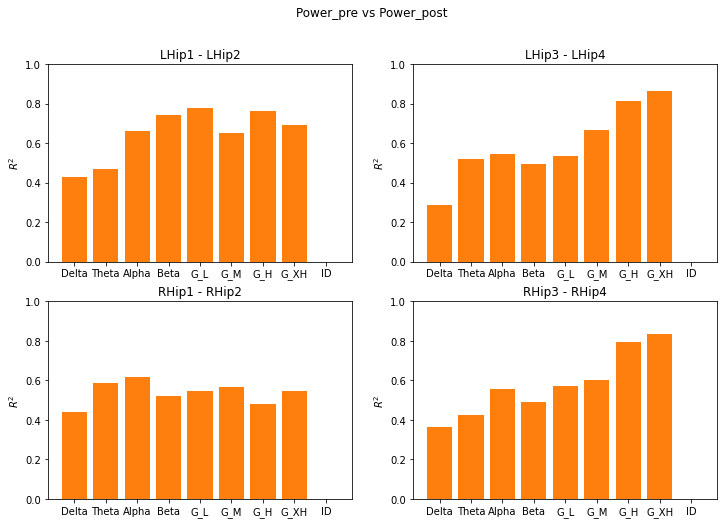

In [ ]:
do_stats(power_and_mem, '$FREQ_pre', '$FREQ_post', xlog=True, ylog=True)

Those bar graphs are nice and all, but how do we *know* that the correlations are actually statistically significant? Well, we can run the t-test on the slopes, and the resulting P-values are some of the smallest I've ever laid my eyes on.. For simplicity's sake, I've run the analysis on all channels together, but I'm sure that if we separated it by channel, the correlations would only be stronger since it would reduce the between-channel variation.

In [ ]:
from scipy.stats import linregress

for freq in freqs:
    results = linregress(np.log10(power_and_mem[freq+'_pre']), np.log10(power_and_mem[freq+'_post']))
    print(f"{freq}: t = {results.slope / results.stderr} P = {results.pvalue}")

Delta: t = 20.735251060770608 P = 5.129435960704045e-66
Theta: t = 27.245349846258947 P = 2.247020944634791e-94
Alpha: t = 28.516144720267423 P = 9.94863718025391e-100
Beta: t = 25.686716794697357 P = 1.0365382648855347e-87
GammaLow: t = 31.620297316978434 P = 1.7947061342203814e-112
GammaMed: t = 29.65408748529595 P = 1.8589690100755467e-104
GammaHigh: t = 32.29666169826174 P = 3.4970598814478064e-115
GammaXHigh: t = 34.20347446946386 P = 1.0846553267654117e-122


Therefore, we can definitively conclude that POST-stim power *does* depend on PRE-stim power

## 1b) Can you predict the CHANGE in power using PRE-stim power?

Let's apply the same approach as last time.

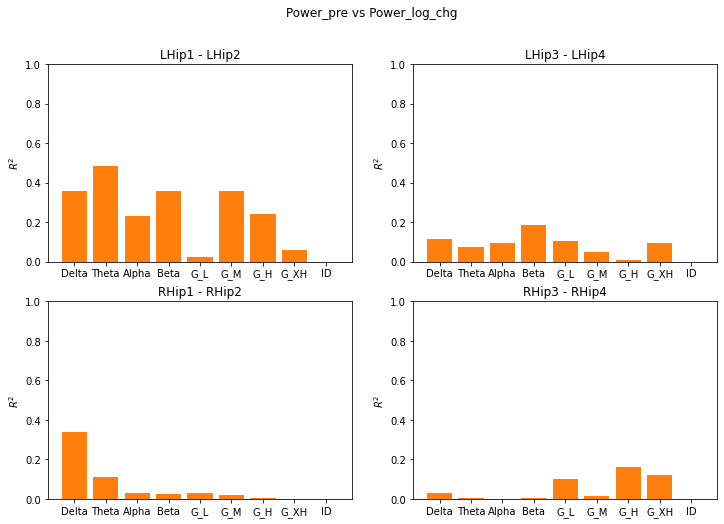

In [ ]:
do_stats(power_and_mem, '$FREQ_pre', '$FREQ_log_chg', xlog=True)

The bar graphs show much smaller R^2 values. It seems like the PRE-stim power has more of an effect on POST-stim power than it does on the CHANGE in power. To me, this indicates that the excitability in response to stimulation is not quite the same as the tissue's "natural" activity level, except maybe in the left anterior hippocampus. I wonder if this is the region that's stimulated first/last.

Whenever I see differences between the channels/contacts/brain regions in response to stimulation, I keep running into the question of whether these differences are due to the stimulation parameters vs active usage of certain circuits causing a differential response. The problem is that each patient has different stim parameters, so I'm not sure how we could elucidate the role of the stim parameters. Maybe separate it out by patient or something. The good news is that this shouldn't affect memory correlations, because I'm pretty sure that if a difference in power between brain regions correlates with memory, that's probably because that brain region is involved in memory.

Anyway, because the $R^2$ values are pretty small this time, and left anterior hippocampus is the only one that shows sizable correlations, I will separate out my t-tests by brain contact this time.

In [ ]:
from scipy.stats import linregress

for chan in hip_chans:
    power_for_chan = power_and_mem[power_and_mem['Channel'] == chan]
    for freq in freqs:
        results = linregress(np.log10(power_for_chan[freq+'_pre']), power_for_chan[freq+'_log_chg'])
        if results.pvalue < 0.05:
            print(f"{chan} {freq}: t = {results.slope / results.stderr} P = {results.pvalue}")
        else:
            print(f"{chan} {freq}: Not significant")
    print("")

LHip1 - LHip2 Delta: t = -6.137420520383326 P = 4.883542304677614e-08
LHip1 - LHip2 Theta: t = -7.971363002643398 P = 2.4701381103859106e-11
LHip1 - LHip2 Alpha: t = -4.525435568531127 P = 2.4880023094992907e-05
LHip1 - LHip2 Beta: t = -6.182304461708118 P = 4.071739711162382e-08
LHip1 - LHip2 GammaLow: Not significant
LHip1 - LHip2 GammaMed: t = -6.179364147843279 P = 4.120562049916765e-08
LHip1 - LHip2 GammaHigh: t = -4.650776133486427 P = 1.5739483618407554e-05
LHip1 - LHip2 GammaXHigh: t = -2.0261385131424645 P = 0.04667591786829241

LHip3 - LHip4 Delta: t = -2.980808274117621 P = 0.003985837451075974
LHip3 - LHip4 Theta: t = -2.352569041703599 P = 0.021545183760228785
LHip3 - LHip4 Alpha: t = -2.692814463912313 P = 0.008913685844089952
LHip3 - LHip4 Beta: t = -3.947133763718718 P = 0.0001900424967993592
LHip3 - LHip4 GammaLow: t = -2.78141798484996 P = 0.006996814587367072
LHip3 - LHip4 GammaMed: Not significant
LHip3 - LHip4 GammaHigh: Not significant
LHip3 - LHip4 GammaXHigh: t 

A lot of them still have pretty strong P-values, especially in the left anterior hippocampus, but it's clear that the relationship is not as strong given the $R^2$ data and the slightly higher (but still very small) P-values. My overall conclusion is that YES, PRE-stim power does predict CHANGE in power, but mostly in the left anterior hippocampus and less so in other areas.

## 2a) Does PRE-stim ECoG power predict memory scores?

Oh boy. Here we go. The memory correlations. The most important part of our work, and also the most complicated. Where to begin.

I have tried many different models, with results that sometimes concur and sometimes differ. I started out by calculating individual correlations between memory scores and ECoG power, and I identified a few relationships. After that, I wanted to isolate the within-subject variation and between-subject variation, so I tried running a multiple regression with dummy vectors for the categorical variable of subject. Based on the overlap between the $R^2$ values, this work suggested that the differences between subjects were more important than the differences within subjects. This is illustrated in the graph below. Finally, I figured out how to implement mixed-effects models that allowed me to treat the subject as a random effect and the various ECoG powers as fixed effects, and these new models showed results that I'm still not sure how to interpret. Let's walk through the results in more detail.

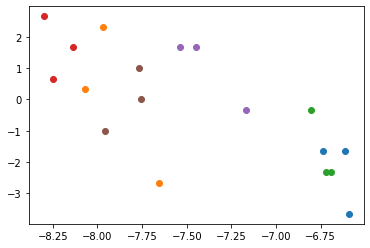

In [ ]:
df_averaged = pd.DataFrame()
for freq in freqs:
    x_for_freq = '$FREQ_post'.replace('$FREQ', freq)
    df_averaged[x_for_freq] = power_and_mem.groupby(['ID', 'Trial', 'Channel']).apply(lambda g: g.eval(x_for_freq)).groupby(['ID', 'Trial', 'Channel']).mean()
df_mems = power_and_mem.groupby(['ID', 'Trial', 'Channel']).mean()
for col in df_mems.columns:
    if col in ['Memory_Score', 'Avg_Sham', 'Change_in_Memory']:
        df_averaged[col] = df_mems[col]
df_averaged = df_averaged.reset_index()

fig, ax = plt.subplots()
power_for_chan = df_averaged[df_averaged['Channel'] == 'LHip3 - LHip4']
for i, pt in enumerate(power_for_chan['ID'].unique()):
    power_for_pt = power_for_chan[power_for_chan['ID'] == pt]
    ax.scatter(np.log10(power_for_pt['Delta_post']), power_for_pt['Memory_Score'] - power_for_pt['Avg_Sham'])

My first work was running simple linear regression between the PRE-stim power on the x side, and raw memory scores, stim-sham memory scores, and three-word memory scores on the y side. For this writeup, I've organized it so that we look at all of the raw memory first, then the stim-sham, then three-word groups.

### Raw Memory Scores

We'll start with the raw memory scores. In order to do this, we need to average out the stims for each trial, since each trial has one memory score but 4 stims.

In [12]:
power_mem_trial = pd.DataFrame()
for freq in freqs:
    x_for_freq = '$FREQ_post'.replace('$FREQ', freq)
    power_mem_trial[x_for_freq] = power_and_mem.groupby(['ID', 'Trial', 'Channel'])[x_for_freq].mean()
    x_for_freq = '$FREQ_pre'.replace('$FREQ', freq)
    power_mem_trial[x_for_freq] = power_and_mem.groupby(['ID', 'Trial', 'Channel'])[x_for_freq].mean()
    x_for_freq = '$FREQ_log_chg'.replace('$FREQ', freq)
    power_mem_trial[x_for_freq] = power_and_mem.groupby(['ID', 'Trial', 'Channel'])[x_for_freq].mean()
    
df_mems = power_and_mem.groupby(['ID', 'Trial', 'Channel']).mean()
for col in df_mems.columns:
    if col in ['Memory_Score', 'Avg_Sham', 'Change_in_Memory']:
        power_mem_trial[col] = df_mems[col]
power_mem_trial = power_mem_trial.reset_index()

Now, let's see what happens when we do one linear regression at a time.

In [13]:
from scipy.stats import linregress

for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    for freq in freqs:
        results = linregress(np.log10(power_for_chan[freq+'_pre']), power_for_chan['Memory_Score'])
        if results.pvalue < 0.05:
            print(f"{chan} {freq}: r = {results.rvalue}, p = {results.pvalue}")

RHip1 - RHip2 GammaLow: r = 0.6927075257974956, p = 0.0014397869735771997
RHip1 - RHip2 GammaMed: r = 0.7886304209812275, p = 0.00010069993500367756
RHip1 - RHip2 GammaHigh: r = 0.483590192250641, p = 0.04202666367518466
RHip3 - RHip4 GammaLow: r = 0.6388748889752464, p = 0.010353054438506521
RHip3 - RHip4 GammaMed: r = 0.6216978166665508, p = 0.013350208341817537


Interesting, we have several significant correlations, all with pretty high R and pretty low P. To confirm, I'm going to try running our strongest correlation, the one for the GammaMed band in RHip1 - RHip2, using a different library (i.e. `statsmodels` instead of `scipy`).

In [14]:
from scipy.stats import linregress

chan = 'RHip1 - RHip2'
freq = 'GammaMed'
power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
model = smf.ols("Memory_Score ~ np.log10(" + freq +"_pre)", power_for_chan)
results = model.fit()
t_test = results.t_test([0, 1], use_t=True)
print(f"{chan} {freq}: |r| = {np.sqrt(results.rsquared)}, p = {t_test.pvalue}")

RHip1 - RHip2 GammaMed: |r| = 0.7886304209812275, p = 0.00010069993500367922


Great! The results are almost exactly the same, which means that I can use both libraries interchangeably, and also indicated that I'm using them correctly.

Next, let's see what happens when we do multiple linear regression with all of the frequencies in a channel simultaneously. I couldn't find a way to do this with `scipy`, but `statsmodels` has an `OLS` that works great.

In [27]:
import statsmodels.formula.api as smf
from IPython.display import display

for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    formula = "Memory_Score ~ "
    for freq in freqs:
        formula += "np.log10(" + freq + "_pre) + "
    formula = formula[:-3] # subtracts out the last " + "
    model = smf.ols(formula, power_for_chan)
    results = model.fit()
    print(chan + ":")
    display(results.summary())

LHip1 - LHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                 -0.236
Method:                 Least Squares   F-statistic:                    0.5945
Date:                Tue, 17 May 2022   Prob (F-statistic):              0.762
Time:                        13:55:34   Log-Likelihood:                -33.416
No. Observations:                  18   AIC:                             84.83
Df Residuals:                       9   BIC:                             92.85
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   12.2729     29.049      0.422      0.683     -53.440      77.986
np.log10(Delta_pre)          7.4706      4.680      1.596      0.145      -3.115      18.057
np.log10(Theta_pre)        -12.5640      6.348     -1.979      0.079     -26.924       1.796
np.log10(Alpha_pre)          5.4515      4.280      1.274      0.235      -4.230      15.133
np.log10(Beta_pre)           1.8227      3.590      0.508      0.624      -6.298       9.943
np.log10(GammaLow_pre)      -6.1907      5.688     -1.088      0.305     -19.058       6.676
np.log10(GammaMed_pre)      -0.3301      4.030     -0.082      0.937      -9.448       8.787
np.log10(GammaHigh_pre)      2.3797      5.868      0.406      0.695     -10.896      15.655
np.log10(GammaXHigh_pre)     2.1729      4.352      0.499      0.630      -7.671      12.017
==============================================================================
Omnibus:                        3.693   Durbin-Watson:                   1.395
Prob(Omnibus):                  0.158   Jarque-Bera (JB):                2.329
Skew:                           0.881   Prob(JB):                        0.312
Kurtosis:                       3.051   Cond. No.                     1.48e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

LHip3 - LHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     1.123
Date:                Tue, 17 May 2022   Prob (F-statistic):              0.430
Time:                        13:55:34   Log-Likelihood:                -31.005
No. Observations:                  18   AIC:                             80.01
Df Residuals:                       9   BIC:                             88.02
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   24.2116     20.976      1.154      0.278     -23.238      71.662
np.log10(Delta_pre)          4.4078      4.273      1.032      0.329      -5.258      14.074
np.log10(Theta_pre)         -4.6801      4.856     -0.964      0.360     -15.664       6.304
np.log10(Alpha_pre)         -4.2429      3.636     -1.167      0.273     -12.468       3.982
np.log10(Beta_pre)           2.2320      3.176      0.703      0.500      -4.952       9.416
np.log10(GammaLow_pre)      -6.7231      3.369     -1.995      0.077     -14.345       0.899
np.log10(GammaMed_pre)      14.7089      6.201      2.372      0.042       0.681      28.737
np.log10(GammaHigh_pre)     -1.4951      5.034     -0.297      0.773     -12.882       9.892
np.log10(GammaXHigh_pre)    -3.2147      3.988     -0.806      0.441     -12.237       5.808
==============================================================================
Omnibus:                        1.330   Durbin-Watson:                   1.681
Prob(Omnibus):                  0.514   Jarque-Bera (JB):                1.141
Skew:                           0.535   Prob(JB):                        0.565
Kurtosis:                       2.386   Cond. No.                     1.24e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

RHip1 - RHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     4.104
Date:                Tue, 17 May 2022   Prob (F-statistic):             0.0250
Time:                        13:55:34   Log-Likelihood:                -22.624
No. Observations:                  18   AIC:                             63.25
Df Residuals:                       9   BIC:                             71.26
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   36.9945     14.883      2.486      0.035       3.327      70.662
np.log10(Delta_pre)         -1.1830      1.726     -0.685      0.510      -5.089       2.723
np.log10(Theta_pre)          0.9642      2.197      0.439      0.671      -4.007       5.935
np.log10(Alpha_pre)          0.2116      3.110      0.068      0.947      -6.825       7.248
np.log10(Beta_pre)          -1.2014      4.029     -0.298      0.772     -10.316       7.913
np.log10(GammaLow_pre)       2.1587      2.063      1.046      0.323      -2.509       6.826
np.log10(GammaMed_pre)       5.4761      2.928      1.870      0.094      -1.147      12.099
np.log10(GammaHigh_pre)     -2.2573      4.014     -0.562      0.588     -11.339       6.824
np.log10(GammaXHigh_pre)    -1.1068      3.356     -0.330      0.749      -8.699       6.486
==============================================================================
Omnibus:                        0.419   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.811   Jarque-Bera (JB):                0.311
Skew:                          -0.281   Prob(JB):                        0.856
Kurtosis:                       2.685   Cond. No.                     1.38e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

RHip3 - RHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     5.896
Date:                Tue, 17 May 2022   Prob (F-statistic):             0.0221
Time:                        13:55:34   Log-Likelihood:                -13.604
No. Observations:                  15   AIC:                             45.21
Df Residuals:                       6   BIC:                             51.58
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   16.5256     19.595      0.843      0.431     -31.422      64.473
np.log10(Delta_pre)          0.8118      2.185      0.372      0.723      -4.535       6.159
np.log10(Theta_pre)         -3.5333      4.027     -0.877      0.414     -13.388       6.321
np.log10(Alpha_pre)          1.3098      2.936      0.446      0.671      -5.874       8.494
np.log10(Beta_pre)           0.9369      3.256      0.288      0.783      -7.029       8.903
np.log10(GammaLow_pre)      -0.1743      2.556     -0.068      0.948      -6.429       6.081
np.log10(GammaMed_pre)       9.3204      3.195      2.917      0.027       1.502      17.139
np.log10(GammaHigh_pre)     -4.0808      3.717     -1.098      0.314     -13.176       5.014
np.log10(GammaXHigh_pre)    -3.5074      2.238     -1.567      0.168      -8.983       1.968
==============================================================================
Omnibus:                        1.855   Durbin-Watson:                   2.128
Prob(Omnibus):                  0.395   Jarque-Bera (JB):                1.316
Skew:                           0.690   Prob(JB):                        0.518
Kurtosis:                       2.553   Cond. No.                     2.11e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This is very interesting. First off, if you zoom in on GammaMed for RHip1 - RHip2, then you'll see that the P-value is pretty different from what we saw in the univariate regressions (0.094 vs 0.0001). This isn't because we're using a different library, but rather because we're using a different statistical model, specifically *multiple* regression and not univariate linear regression. I'm not sure what the difference is in interpretation, so I'll have to consult with John on that, but my first guess would be that it has to do with the multicollinearity.

Speaking of which, you'll notice that the bottom of each table has a big disclaimer that "the condition number is large..\[which\] might indicate that there are strong multicollinearity." This makes sense, since brains with high power in one frequency band probably have globally high power, which is the underlying variable that explains the others. I don't know enough stats to understand why multicollinearity is a problem, so I'll have to ask John about that, too. My interpretation is that these frequency bands must have information that is not collinear with the other frequencies, but I have no idea if that is the correct way to interpret the results

Finally, notice that the overall $R^2$ and F-test for the multiple regression are significant for the right hippocampus, posterior > anterior. This is interesting because it's the opposite laterality from what we've seen for most of the POST-stim power and CHANGE in power correlations. We'll see if that's still the case later.

Next, we move onto mixed effects analyses. This is similar to the multiple linear regression that we just ran, but it accounts for differences between patients. Each group of 3 trials from the same patient is treated as a random effect, and as far as I understand, it looks for fixed effects that occur within each group.

In [16]:
import statsmodels.formula.api as smf
from IPython.display import display

for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    formula = "Memory_Score ~ "
    for freq in freqs:
        formula += "np.log10(" + freq + "_pre) + "
    formula = formula[:-3] # subtracts out the last " + "
    model = smf.mixedlm(formula, power_for_chan, groups=power_for_chan['ID'])
    results = model.fit()
    print(chan + ":")
    display(results.summary())

LHip1 - LHip2:


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:                MixedLM    Dependent Variable:    Memory_Score
No. Observations:     18         Method:                REML        
No. Groups:           6          Scale:                 2.1530      
Min. group size:      3          Log-Likelihood:        -17.6978    
Max. group size:      3          Converged:             Yes         
Mean group size:      3.0                                           
--------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------
Intercept                16.058   29.363  0.547 0.584 -41.492 73.609
np.log10(Delta_pre)       5.323    3.657  1.455 0.146  -1.846 12.491
np.log10(Theta_pre)      -8.223    5.149 -1.597 0.110 -18.315  1.869
np.log10(Alpha_pre)       3.196    3.552  0.900 0.368  -3.766 10.157
np.log10(Beta_pre)        2.749    2.515  1.093 0.274  -2.179  7.678
np.log10(GammaLow_pre)   -5.659    4.235 -1.336 0.181 -13.959  2.641
np.log10(GammaMed_pre)   -2.106    2.800 -0.752 0.452  -7.594  3.382
np.log10(GammaHigh_pre)   3.882    5.102  0.761 0.447  -6.119 13.882
np.log10(GammaXHigh_pre)  1.647    4.607  0.358 0.721  -7.382 10.676
Group Var                 3.759    3.127                            
====================================================================

"""

LHip3 - LHip4:


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:                MixedLM    Dependent Variable:    Memory_Score
No. Observations:     18         Method:                REML        
No. Groups:           6          Scale:                 2.4264      
Min. group size:      3          Log-Likelihood:        -17.3716    
Max. group size:      3          Converged:             Yes         
Mean group size:      3.0                                           
--------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------
Intercept                27.598   29.687  0.930 0.353 -30.587 85.782
np.log10(Delta_pre)       4.763    3.588  1.327 0.184  -2.269 11.796
np.log10(Theta_pre)      -5.107    4.370 -1.169 0.243 -13.671  3.457
np.log10(Alpha_pre)      -1.476    3.931 -0.375 0.707  -9.181  6.229
np.log10(Beta_pre)        1.244    3.086  0.403 0.687  -4.804  7.292
np.log10(GammaLow_pre)   -5.381    3.540 -1.520 0.128 -12.320  1.557
np.log10(GammaMed_pre)   11.279    6.198  1.820 0.069  -0.868 23.426
np.log10(GammaHigh_pre)  -2.470    4.258 -0.580 0.562 -10.816  5.876
np.log10(GammaXHigh_pre) -1.163    4.134 -0.281 0.778  -9.265  6.940
Group Var                 2.362    2.693                            
====================================================================

"""

RHip1 - RHip2:


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:                MixedLM    Dependent Variable:    Memory_Score
No. Observations:     18         Method:                REML        
No. Groups:           6          Scale:                 1.1373      
Min. group size:      3          Log-Likelihood:        -14.2876    
Max. group size:      3          Converged:             Yes         
Mean group size:      3.0                                           
--------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------
Intercept                41.149   18.481  2.227 0.026   4.928 77.371
np.log10(Delta_pre)      -1.236    1.581 -0.782 0.434  -4.335  1.863
np.log10(Theta_pre)       0.840    1.977  0.425 0.671  -3.034  4.715
np.log10(Alpha_pre)       0.747    2.962  0.252 0.801  -5.058  6.551
np.log10(Beta_pre)       -2.001    3.831 -0.522 0.602  -9.509  5.508
np.log10(GammaLow_pre)    3.077    2.485  1.238 0.216  -1.793  7.948
np.log10(GammaMed_pre)    5.900    2.868  2.057 0.040   0.278 11.522
np.log10(GammaHigh_pre)  -3.903    4.336 -0.900 0.368 -12.401  4.595
np.log10(GammaXHigh_pre)  0.033    3.589  0.009 0.993  -7.001  7.066
Group Var                 0.628    1.442                            
====================================================================

"""

RHip3 - RHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:                MixedLM    Dependent Variable:    Memory_Score
No. Observations:     15         Method:                REML        
No. Groups:           5          Scale:                 0.8977      
Min. group size:      3          Log-Likelihood:        -5.5831     
Max. group size:      3          Converged:             Yes         
Mean group size:      3.0                                           
--------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------
Intercept                16.530   17.330  0.954 0.340 -17.437 50.497
np.log10(Delta_pre)       0.811    1.819  0.446 0.656  -2.754  4.377
np.log10(Theta_pre)      -3.532    3.169 -1.115 0.265  -9.743  2.679
np.log10(Alpha_pre)       1.309    2.268  0.577 0.564  -3.136  5.754
np.log10(Beta_pre)        0.938    2.666  0.352 0.725  -4.287  6.163
np.log10(GammaLow_pre)   -0.174    1.908 -0.091 0.928  -3.914  3.567
np.log10(GammaMed_pre)    9.319    1.996  4.668 0.000   5.406 13.232
np.log10(GammaHigh_pre)  -4.081    3.496 -1.167 0.243 -10.934  2.771
np.log10(GammaXHigh_pre) -3.507    1.188 -2.951 0.003  -5.836 -1.177
Group Var                 0.000                                     
====================================================================

"""

Before correcting for multiple comparisons, the significant results here are that GammaMed in Right Anterior and GammaMed in Right Posterior are both positively correlated with memory scores. Both of these relationships were also seen in the simple linear regressions,and the Righ Posterior also showed up in the multiple regression. Overall convergent results suggesting that seeing high levels of these Gamma frequencies in the PRE-stim ECoG are indicative or higher RAW memory scores.

Overall, if we just take everything at P < 0.05 and ignore multiple comparisons, our results are that RAW memory scores can be explained by differences in PRE-stim power in:
* RHip1 - RHip2 GammaLow
* RHip1 - RHip2 GammaMed (*best*)
* RHip1 - RHip2 GammaHigh
* RHip3 - RHip4 GammaLow
* RHip3 - RHip4 GammaMed

But if you look at the multiple regression, only the GammaMed in LHip3 - LHip4 and RHip3 - RHip4 have coefficients that are significantly different from zero.

Looking at all frequencies together, the Right hippocampus seems to be most correlated with raw memory.

Separating out the effects by each patient, RHip1 - RHip2 and RHip3 - RHip4 are positively correlated with raw memory.

### Change in Memory

We're pretty much going to do the exact same statistical analyses as we did for PRE-stim power and RAW memory, but now with CHANGE in memory, i.e. single regression, multiple regression, and mixed effects. Keep in mind that the rationale for looking at CHANGE in memory is that it represents "how much the subject improved with stimulation," and we are assuming improvement based on the previous paper.

In [18]:
from scipy.stats import linregress

for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    for freq in freqs:
        results = linregress(np.log10(power_for_chan[freq+'_pre']), power_for_chan['Memory_Score'] - power_for_chan['Avg_Sham'])
        if results.pvalue < 0.05:
            print(f"{chan} {freq}: r = {results.rvalue}, p = {results.pvalue}")

LHip3 - LHip4 GammaLow: r = -0.4882467616323758, p = 0.039805947761584526
RHip1 - RHip2 GammaLow: r = 0.5033182144036782, p = 0.03322936454360611
RHip1 - RHip2 GammaMed: r = 0.5614792712367382, p = 0.01532188861693486
RHip3 - RHip4 GammaLow: r = 0.569075224112467, p = 0.02682662069630029


After running the simple regressions, we can see a few interesting correlations, again in the gamma range. I'm beginning to think that Delta is the most responsive to stimulation and Gamma is the most related to memory. Anyway, comparing to the correlations for RAW memory, which I've pasted in the next cell, we can see that the CHANGE-in-memory correlations are decent but in terms of both r and p, nowhere near as strong as the relationship with RAW memory. Especially if you look at the GammaLow in RHip1 - RHip2 (r = 0.693, P = 0.001), and the GammaMed in RHip1 - RHip2 (r = 0.789, P=0.0001)

In [21]:
from scipy.stats import linregress

for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    for freq in freqs:
        results = linregress(np.log10(power_for_chan[freq+'_pre']), power_for_chan['Memory_Score'])
        if results.pvalue < 0.05:
            print(f"{chan} {freq}: r = {results.rvalue}, p = {results.pvalue}")

RHip1 - RHip2 GammaLow: r = 0.6927075257974956, p = 0.0014397869735771997
RHip1 - RHip2 GammaMed: r = 0.7886304209812275, p = 0.00010069993500367756
RHip1 - RHip2 GammaHigh: r = 0.483590192250641, p = 0.04202666367518466
RHip3 - RHip4 GammaLow: r = 0.6388748889752464, p = 0.010353054438506521
RHip3 - RHip4 GammaMed: r = 0.6216978166665508, p = 0.013350208341817537


Still, it's interesting that of the 4 channel-frequency bins that are correlated with CHANGE in memory, three of them were also correlated with RAW memory. LHip3 - LHip4 is the only new one, and it's also interesting that it's the only negative one.

Moving onto multiple regression:

In [28]:
import statsmodels.formula.api as smf
from IPython.display import display

for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    formula = "Change_in_Memory ~ "
    for freq in freqs:
        formula += "np.log10(" + freq + "_pre) + "
    formula = formula[:-3] # subtracts out the last " + "
    model = smf.ols(formula, power_for_chan)
    results = model.fit()
    print(chan + ":")
    display(results.summary())

LHip1 - LHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Change_in_Memory   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                 -0.224
Method:                 Least Squares   F-statistic:                    0.6116
Date:                Tue, 17 May 2022   Prob (F-statistic):              0.750
Time:                        13:55:45   Log-Likelihood:                -32.436
No. Observations:                  18   AIC:                             82.87
Df Residuals:                       9   BIC:                             90.89
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.4327     27.509     -0.016      0.988     -62.663      61.797
np.log10(Delta_pre)          7.8738      4.432      1.777      0.109      -2.151      17.899
np.log10(Theta_pre)        -10.6569      6.011     -1.773      0.110     -24.256       2.942
np.log10(Alpha_pre)          3.4827      4.053      0.859      0.412      -5.685      12.651
np.log10(Beta_pre)           1.6731      3.399      0.492      0.634      -6.017       9.363
np.log10(GammaLow_pre)      -4.1646      5.387     -0.773      0.459     -16.350       8.021
np.log10(GammaMed_pre)      -0.8144      3.817     -0.213      0.836      -9.449       7.820
np.log10(GammaHigh_pre)     -0.5382      5.557     -0.097      0.925     -13.110      12.033
np.log10(GammaXHigh_pre)     3.0852      4.121      0.749      0.473      -6.237      12.408
==============================================================================
Omnibus:                        2.469   Durbin-Watson:                   1.506
Prob(Omnibus):                  0.291   Jarque-Bera (JB):                1.502
Skew:                           0.707   Prob(JB):                        0.472
Kurtosis:                       2.937   Cond. No.                     1.48e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

LHip3 - LHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Change_in_Memory   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     1.324
Date:                Tue, 17 May 2022   Prob (F-statistic):              0.341
Time:                        13:55:46   Log-Likelihood:                -29.342
No. Observations:                  18   AIC:                             76.68
Df Residuals:                       9   BIC:                             84.70
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -8.5673     19.125     -0.448      0.665     -51.830      34.695
np.log10(Delta_pre)          4.4045      3.896      1.131      0.287      -4.409      13.217
np.log10(Theta_pre)         -5.2142      4.427     -1.178      0.269     -15.229       4.801
np.log10(Alpha_pre)         -3.3975      3.315     -1.025      0.332     -10.897       4.102
np.log10(Beta_pre)           2.9386      2.896      1.015      0.337      -3.612       9.489
np.log10(GammaLow_pre)      -7.0202      3.072     -2.285      0.048     -13.969      -0.071
np.log10(GammaMed_pre)      11.2710      5.654      1.993      0.077      -1.519      24.061
np.log10(GammaHigh_pre)     -2.9970      4.589     -0.653      0.530     -13.379       7.385
np.log10(GammaXHigh_pre)    -1.4632      3.636     -0.402      0.697      -9.689       6.763
==============================================================================
Omnibus:                        2.344   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.310   Jarque-Bera (JB):                1.074
Skew:                           0.055   Prob(JB):                        0.584
Kurtosis:                       1.808   Cond. No.                     1.24e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

RHip1 - RHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Change_in_Memory   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     2.646
Date:                Tue, 17 May 2022   Prob (F-statistic):             0.0844
Time:                        13:55:46   Log-Likelihood:                -22.790
No. Observations:                  18   AIC:                             63.58
Df Residuals:                       9   BIC:                             71.59
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   10.1464     15.021      0.675      0.516     -23.833      44.126
np.log10(Delta_pre)         -0.6889      1.742     -0.395      0.702      -4.631       3.253
np.log10(Theta_pre)         -0.0005      2.218     -0.000      1.000      -5.017       5.016
np.log10(Alpha_pre)          0.7226      3.139      0.230      0.823      -6.379       7.824
np.log10(Beta_pre)          -1.0007      4.066     -0.246      0.811     -10.200       8.198
np.log10(GammaLow_pre)       2.2293      2.082      1.071      0.312      -2.481       6.940
np.log10(GammaMed_pre)       5.0465      2.955      1.708      0.122      -1.638      11.731
np.log10(GammaHigh_pre)     -5.3071      4.052     -1.310      0.223     -14.473       3.858
np.log10(GammaXHigh_pre)     0.1047      3.387      0.031      0.976      -7.558       7.768
==============================================================================
Omnibus:                        1.513   Durbin-Watson:                   2.646
Prob(Omnibus):                  0.469   Jarque-Bera (JB):                1.149
Skew:                          -0.584   Prob(JB):                        0.563
Kurtosis:                       2.587   Cond. No.                     1.38e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

RHip3 - RHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Change_in_Memory   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     6.107
Date:                Tue, 17 May 2022   Prob (F-statistic):             0.0203
Time:                        13:55:46   Log-Likelihood:                -10.306
No. Observations:                  15   AIC:                             38.61
Df Residuals:                       6   BIC:                             44.99
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -9.9578     15.728     -0.633      0.550     -48.444      28.528
np.log10(Delta_pre)         -0.5477      1.754     -0.312      0.765      -4.839       3.744
np.log10(Theta_pre)         -0.7060      3.233     -0.218      0.834      -8.616       7.204
np.log10(Alpha_pre)         -1.2271      2.357     -0.521      0.621      -6.993       4.539
np.log10(Beta_pre)           3.4868      2.613      1.334      0.231      -2.907       9.881
np.log10(GammaLow_pre)       0.2268      2.052      0.111      0.916      -4.794       5.248
np.log10(GammaMed_pre)       7.0115      2.565      2.734      0.034       0.736      13.287
np.log10(GammaHigh_pre)     -7.4595      2.984     -2.500      0.047     -14.760      -0.159
np.log10(GammaXHigh_pre)    -1.4765      1.796     -0.822      0.442      -5.872       2.919
==============================================================================
Omnibus:                        1.691   Durbin-Watson:                   2.656
Prob(Omnibus):                  0.429   Jarque-Bera (JB):                1.147
Skew:                           0.650   Prob(JB):                        0.564
Kurtosis:                       2.619   Cond. No.                     2.11e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

At significance level of a = 0.05, our significant correlations are:
* GammaLow in LHip3 - LHip4: P = 0.048, negative direction
* GammaMed in RHip3 - RHip4: P = 0.034, positive direction
* GammaHigh in RHip3 - RHip4: P = 0.047, negative direction

When we were looking at RAW memory scores, the significant correlations were GammaMed in RHip3 - RHip4 and LHip3 - LHip4, and both were positive. The first relationship shows up here as well, but not the second.

As before, taking all frequencies together and comparing channels, Right Hipocampus is the strongest predictor of memory, posterior > anterior.

Finally, let's look at the mixed effects models:

In [30]:
import statsmodels.formula.api as smf
from IPython.display import display

for chan in hip_chans:
    power_for_chan = power_mem_trial[power_mem_trial['Channel'] == chan]
    formula = "Change_in_Memory ~ "
    for freq in freqs:
        formula += "np.log10(" + freq + "_pre) + "
    formula = formula[:-3] # subtracts out the last " + "
    model = smf.mixedlm(formula, power_for_chan, groups=power_for_chan['ID'])
    results = model.fit()
    print(chan + ":")
    display(results.summary())

LHip1 - LHip2:


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:              MixedLM   Dependent Variable:   Change_in_Memory
No. Observations:   18        Method:               REML            
No. Groups:         6         Scale:                2.2847          
Min. group size:    3         Log-Likelihood:       -17.7265        
Max. group size:    3         Converged:            Yes             
Mean group size:    3.0                                             
--------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------
Intercept                -3.109   28.856 -0.108 0.914 -59.665 53.448
np.log10(Delta_pre)       5.819    3.810  1.527 0.127  -1.648 13.287
np.log10(Theta_pre)      -7.870    5.210 -1.511 0.131 -18.080  2.341
np.log10(Alpha_pre)       2.887    3.598  0.802 0.422  -4.166  9.939
np.log10(Beta_pre)        2.460    2.580  0.954 0.340  -2.597  7.518
np.log10(GammaLow_pre)   -5.372    4.343 -1.237 0.216 -13.885  3.141
np.log10(GammaMed_pre)   -2.273    2.884 -0.788 0.430  -7.925  3.379
np.log10(GammaHigh_pre)   2.074    5.206  0.398 0.690  -8.130 12.278
np.log10(GammaXHigh_pre)  2.030    4.570  0.444 0.657  -6.927 10.986
Group Var                 3.245    2.959                            
====================================================================

"""

c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


LHip3 - LHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.008522
  warnings.warn(msg, ConvergenceWarning)
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2705: RuntimeWarning: invalid v

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:              MixedLM   Dependent Variable:   Change_in_Memory
No. Observations:   18        Method:               REML            
No. Groups:         6         Scale:                3.0503          
Min. group size:    3         Log-Likelihood:       -16.9250        
Max. group size:    3         Converged:            No              
Mean group size:    3.0                                             
--------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------
Intercept                -8.564   14.910 -0.574 0.566 -37.786 20.658
np.log10(Delta_pre)       4.405    3.759  1.172 0.241  -2.962 11.771
np.log10(Theta_pre)      -5.214    4.373 -1.193 0.233 -13.784  3.356
np.log10(Alpha_pre)      -3.396                                     
np.log10(Beta_pre)        2.938    1.044  2.815 0.005   0.892  4.984
np.log10(GammaLow_pre)   -7.019                                     
np.log10(GammaMed_pre)   11.269                                     
np.log10(GammaHigh_pre)  -2.998    4.128 -0.726 0.468 -11.088  5.093
np.log10(GammaXHigh_pre) -1.462    2.246 -0.651 0.515  -5.865  2.940
Group Var                 0.001                                     
====================================================================

"""

RHip1 - RHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:              MixedLM   Dependent Variable:   Change_in_Memory
No. Observations:   18        Method:               REML            
No. Groups:         6         Scale:                1.4732          
Min. group size:    3         Log-Likelihood:       -14.5609        
Max. group size:    3         Converged:            Yes             
Mean group size:    3.0                                             
--------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------
Intercept                10.150   11.537  0.880 0.379 -12.461 32.762
np.log10(Delta_pre)      -0.689    1.735 -0.397 0.691  -4.090  2.712
np.log10(Theta_pre)      -0.000    2.212 -0.000 1.000  -4.336  4.335
np.log10(Alpha_pre)       0.723    3.104  0.233 0.816  -5.360  6.806
np.log10(Beta_pre)       -1.001    3.957 -0.253 0.800  -8.757  6.755
np.log10(GammaLow_pre)    2.230    1.506  1.481 0.139  -0.721  5.181
np.log10(GammaMed_pre)    5.046    2.955  1.708 0.088  -0.745 10.838
np.log10(GammaHigh_pre)  -5.308    3.713 -1.430 0.153 -12.585  1.969
np.log10(GammaXHigh_pre)  0.105    2.994  0.035 0.972  -5.762  5.973
Group Var                 0.000                                     
====================================================================

"""

c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


RHip3 - RHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:              MixedLM   Dependent Variable:   Change_in_Memory
No. Observations:   15        Method:               REML            
No. Groups:         5         Scale:                0.5785          
Min. group size:    3         Log-Likelihood:       -4.2641         
Max. group size:    3         Converged:            Yes             
Mean group size:    3.0                                             
--------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------
Intercept                -9.958   15.765 -0.632 0.528 -40.857 20.941
np.log10(Delta_pre)      -0.548    1.850 -0.296 0.767  -4.173  3.078
np.log10(Theta_pre)      -0.706    3.403 -0.207 0.836  -7.376  5.963
np.log10(Alpha_pre)      -1.227    2.822 -0.435 0.664  -6.757  4.303
np.log10(Beta_pre)        3.487    2.640  1.321 0.187  -1.687  8.661
np.log10(GammaLow_pre)    0.227    2.067  0.110 0.913  -3.825  4.279
np.log10(GammaMed_pre)    7.012    2.646  2.650 0.008   1.825 12.198
np.log10(GammaHigh_pre)  -7.459    3.091 -2.413 0.016 -13.518 -1.400
np.log10(GammaXHigh_pre) -1.477    1.890 -0.781 0.435  -5.181  2.228
Group Var                 0.000    0.929                            
====================================================================

"""

First off, it's important to note the warnings about maximum likelihood estimation failing to converge. I think this may undermine some of the results, but then again, it also says that the model converged in the end, so maybe it just had to try a different method.

Next, let's look at the significant findings for the mixed effects model:
* Beta in LHip3 - LHip4, P = 0.005, positive direction
* GammaMed in RHip3 - RHip4, P = 0.008, positive direction
* GammaHigh in RHip3 - RHip4, P = 0.016, negative direction

The brain is a complex thing, so interpreting all of these correlations is challenging, especially when considering that we haven't applied FDR. Still, it's worth noting that the GammaMed and GammaHigh in Rhip3 - RHip4 were also seen in the multiple regression, although the P-values are lower now that we've isolated the fixed effects from the random effects.

Overall, if we just take everything at P < 0.05 and ignore multiple comparisons, our results are that CHANGE in memory scores can be explained by differences in PRE-stim power in:
* LHip3 - LHip4 GammaLow
* RHip1 - RHip2 GammaLow
* RHip1 - RHip2 GammaMed
* RHip3 - RHip4 GammaLow

But if you look at the multiple regression, the significant results are:
* GammaLow in LHip3 - LHip4: P = 0.048, negative direction
* GammaMed in RHip3 - RHip4: P = 0.034, positive direction
* GammaHigh in RHip3 - RHip4: P = 0.047, negative direction

Looking at all frequencies together, the Right hippocampus seems to be most correlated with change in memory, same as it was for raw memory.

Separating out the effects by each patient, we have:
* Beta in LHip3 - LHip4, P = 0.005, positive direction
* GammaMed in RHip3 - RHip4, P = 0.008, positive direction
* GammaHigh in RHip3 - RHip4, P = 0.016, negative direction

Going by P-value alone, the PRE-stim Beta in LHip3 - LHip4 seems to be the best predictor of CHANGE in memory, although this is only visible once you remove differences between patients (random effects).GammaHigh in RHip3- RHip4 seems to play an important role no matter which analysis you look at, although the relationships are not as strong as they were for RAW memory

## 2b) Does the CHANGE in ECoG power predict memory scores?